## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [1]:
#!pip install -r requirements.txt

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ve.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros      TRM  Precio Interno
0   2020-01-01      1.289946  3277.14        975000.0
1   2020-01-02      0.735046  3277.14        945000.0
2   2020-01-03      0.591834  3258.84        940000.0
3   2020-01-04      1.367154  3262.05        930000.0
4   2020-01-05      1.505321  3262.05        920000.0
..         ...           ...      ...             ...
913 2022-07-02      0.778572  4198.77       2270000.0
914 2022-07-03      0.819483  4198.77       2270000.0
915 2022-07-04      0.843804  4198.77       2270000.0
916 2022-07-05      0.850985  4198.77       2280000.0
917 2022-07-06      0.840437  4259.86       2302000.0

[918 rows x 4 columns]

---

## Desarrollo del modelo

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(637, 5, 3) (637, 1)
(271, 5, 3) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.9292 - mae: 0.7057 - val_loss: 1.4453 - val_mae: 0.7955
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9229 - mae: 0.7078 - val_loss: 1.4405 - val_mae: 0.7948
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9198 - mae: 0.7095 - val_loss: 1.4347 - val_mae: 0.7958
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9168 - mae: 0.7074 - val_loss: 1.4313 - val_mae: 0.7959
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9147 - mae: 0.7080 - val_loss: 1.4296 - val_mae: 0.7964
Epoch 6/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9129 - mae: 0.7073 - val_loss: 1.4274 - val_mae: 0.7972
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9114 - mae: 0.7061 - val_loss: 1.4245 - val_mae: 0.7959
Epoch 8/100
32/32 [=====================

Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8592 - mae: 0.6901 - val_loss: 1.5188 - val_mae: 0.8774
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8591 - mae: 0.6899 - val_loss: 1.5217 - val_mae: 0.8793
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8580 - mae: 0.6888 - val_loss: 1.5242 - val_mae: 0.8810
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8573 - mae: 0.6886 - val_loss: 1.5258 - val_mae: 0.8822
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8570 - mae: 0.6900 - val_loss: 1.5353 - val_mae: 0.8858
Epoch 68/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8564 - mae: 0.6895 - val_loss: 1.5380 - val_mae: 0.8885
Epoch 69/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8555 - mae: 0.6886 - val_loss: 1.5442 - val_mae: 0.8909
Epoch 70/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

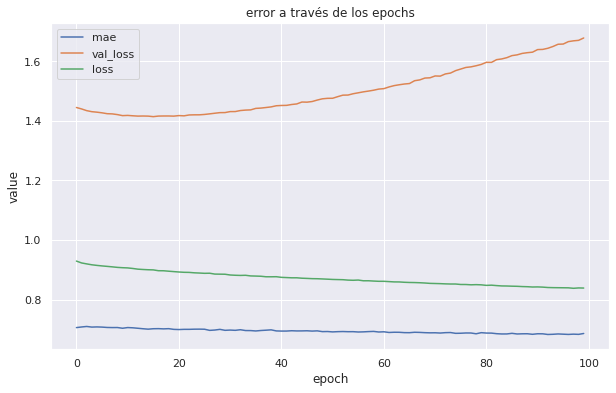

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.56626238210608
MAE is : 0.9216483026490075
RMSE is : 1.2515040479783035
MAPE is : 46.396688610364976
Evaluation metric results:
MSE is : 2.5352313066866734
MAE is : 1.39611955480777
RMSE is : 1.5922409700440048
MAPE is : 81.9348347303396
(637, 5, 3) (637, 1)
(271, 5, 3) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9462 - mae: 0.7083 - val_loss: 1.4597 - val_mae: 0.8073
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9291 - mae: 0.7074 - val_loss: 1.4456 - val_mae: 0.8067
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9227 - mae: 0.7096 - val_loss: 1.4354 - val_mae: 0.8089
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9173 - mae: 0.7063 - val_loss: 1.4299 - val_mae: 0.8098
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9143 - mae: 0.7081 - val_loss: 

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8602 - mae: 0.6913 - val_loss: 1.6776 - val_mae: 0.9486
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8609 - mae: 0.6936 - val_loss: 1.6819 - val_mae: 0.9516
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8595 - mae: 0.6893 - val_loss: 1.6942 - val_mae: 0.9543
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8581 - mae: 0.6916 - val_loss: 1.7074 - val_mae: 0.9608
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8581 - mae: 0.6914 - val_loss: 1.7132 - val_mae: 0.9633
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8566 - mae: 0.6893 - val_loss: 1.7203 - val_mae: 0.9668
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8558 - mae: 0.6897 - val_loss: 1.7247 - val_mae: 0.9692
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0.

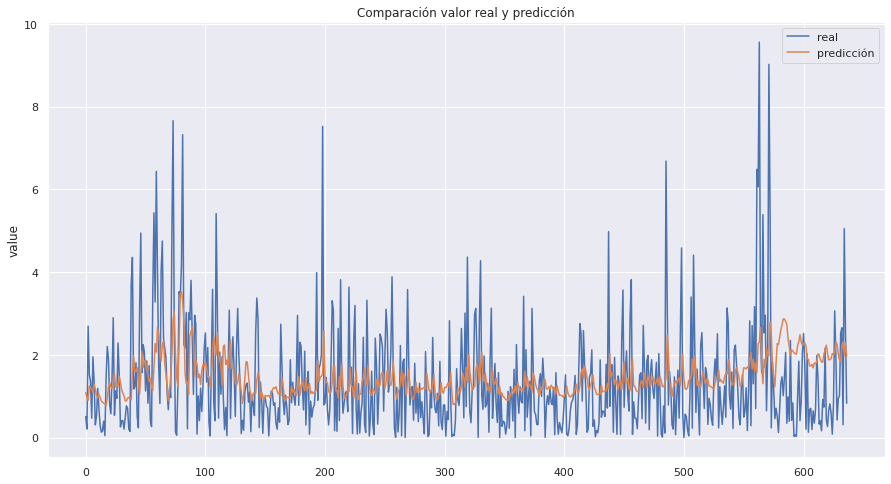

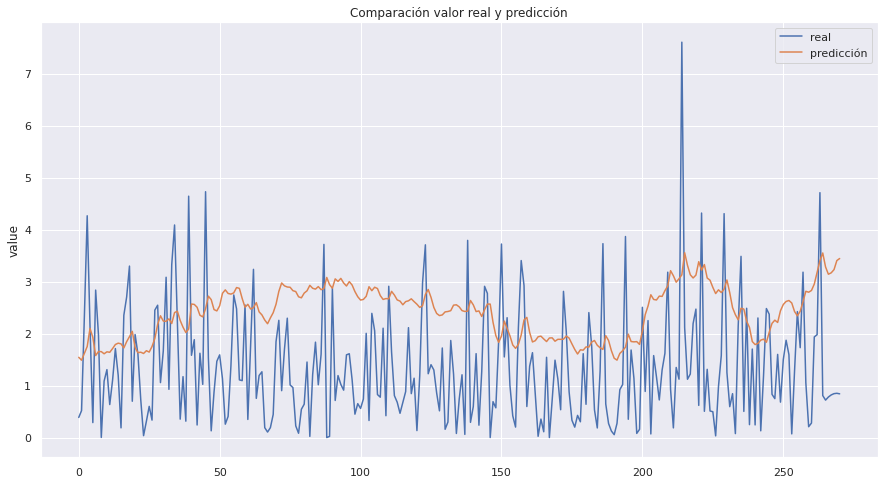

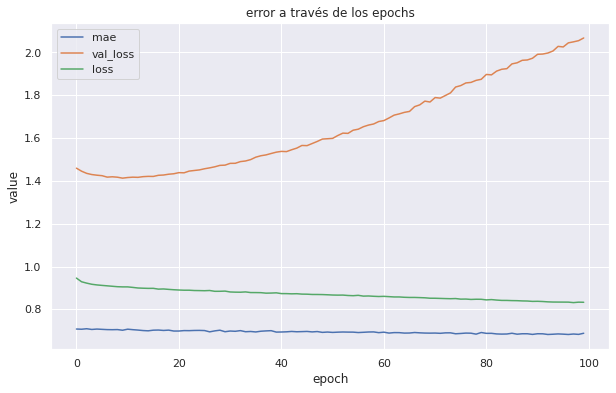

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.6795880813931814
MAE is : 0.9585216377858702
RMSE is : 1.295989228887795
MAPE is : 48.799045357590245
Evaluation metric results:
MSE is : 4.955887364020547
MAE is : 1.9649659067074348
RMSE is : 2.226182239624723
MAPE is : 115.40298006547307
(637, 5, 3) (637, 1)
(271, 5, 3) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9573 - mae: 0.7184 - val_loss: 1.4841 - val_mae: 0.8094
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9398 - mae: 0.7167 - val_loss: 1.4615 - val_mae: 0.8055
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9329 - mae: 0.7159 - val_loss: 1.4410 - val_mae: 0.8057
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9261 - mae: 0.7117 - val_loss: 1.4342 - val_mae: 0.8057
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9225 - mae: 0.7143 - val_lo

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8412 - mae: 0.6846 - val_loss: 2.1097 - val_mae: 1.1007
Epoch 61/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8419 - mae: 0.6889 - val_loss: 2.1357 - val_mae: 1.1107
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8408 - mae: 0.6824 - val_loss: 2.1326 - val_mae: 1.1072
Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8380 - mae: 0.6868 - val_loss: 2.1899 - val_mae: 1.1269
Epoch 64/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8388 - mae: 0.6857 - val_loss: 2.1947 - val_mae: 1.1289
Epoch 65/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8360 - mae: 0.6831 - val_loss: 2.2173 - val_mae: 1.1361
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8347 - mae: 0.6844 - val_loss: 2.2485 - val_mae: 1.1459
Epoch 67/100
32/32 [==============================] - 0s 7ms/step - loss: 0

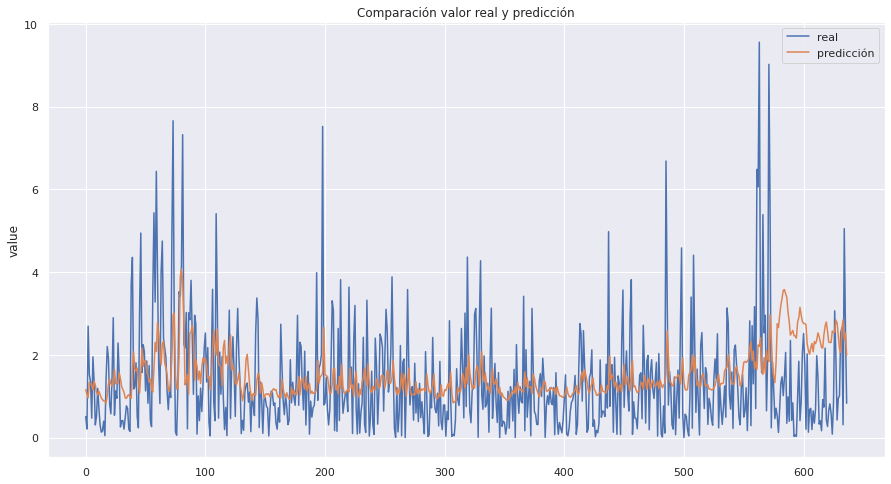

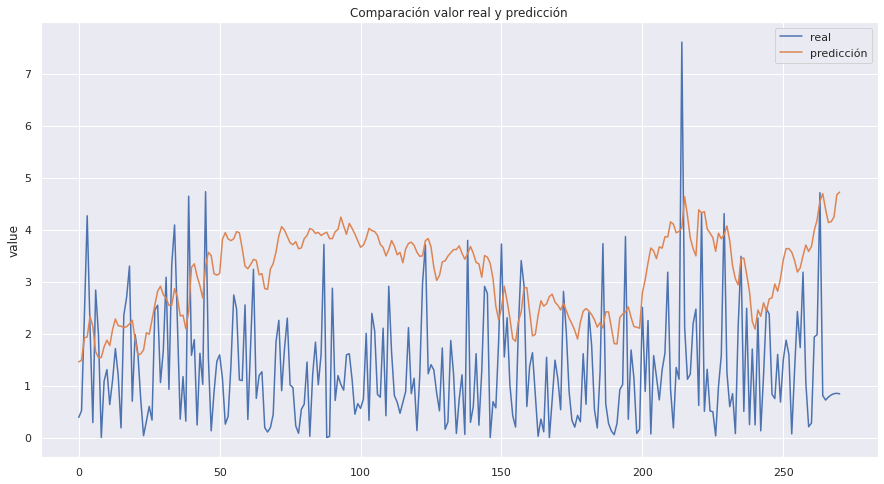

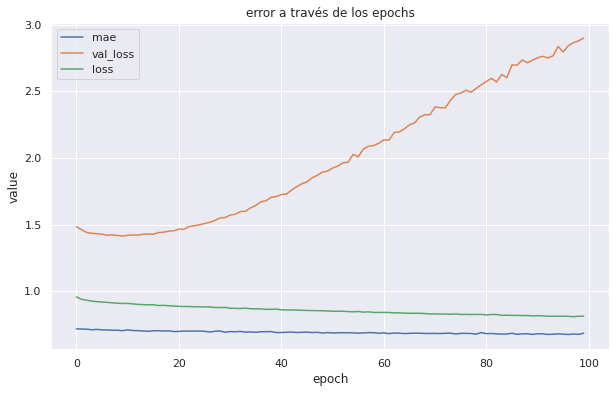

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.91060437128946
MAE is : 1.0117519191725164
RMSE is : 1.3822461326729982
MAPE is : 51.81560317846532
Evaluation metric results:
MSE is : 13.073350769342426
MAE is : 3.2389343793268144
RMSE is : 3.6157088889099502
MAPE is : 182.92241425655433
(637, 5, 3) (637, 1)
(271, 5, 3) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 25ms/step - loss: 0.9428 - mae: 0.7161 - val_loss: 1.4480 - val_mae: 0.7916
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9267 - mae: 0.7146 - val_loss: 1.4328 - val_mae: 0.7887
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9225 - mae: 0.7136 - val_loss: 1.4209 - val_mae: 0.7904
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9140 - mae: 0.7070 - val_loss: 1.4212 - val_mae: 0.7921
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9114 - mae: 0.7124 - val_los

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8220 - mae: 0.6748 - val_loss: 2.8144 - val_mae: 1.2985
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8213 - mae: 0.6848 - val_loss: 2.8957 - val_mae: 1.3206
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8224 - mae: 0.6736 - val_loss: 2.8120 - val_mae: 1.2974
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8174 - mae: 0.6823 - val_loss: 2.9633 - val_mae: 1.3368
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8205 - mae: 0.6806 - val_loss: 2.9954 - val_mae: 1.3458
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8148 - mae: 0.6744 - val_loss: 2.9881 - val_mae: 1.3440
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8133 - mae: 0.6776 - val_loss: 3.1515 - val_mae: 1.3839
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

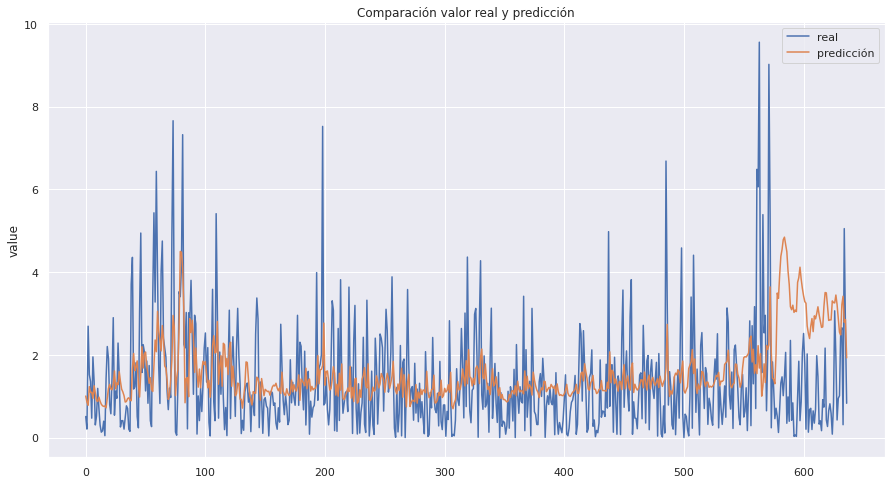

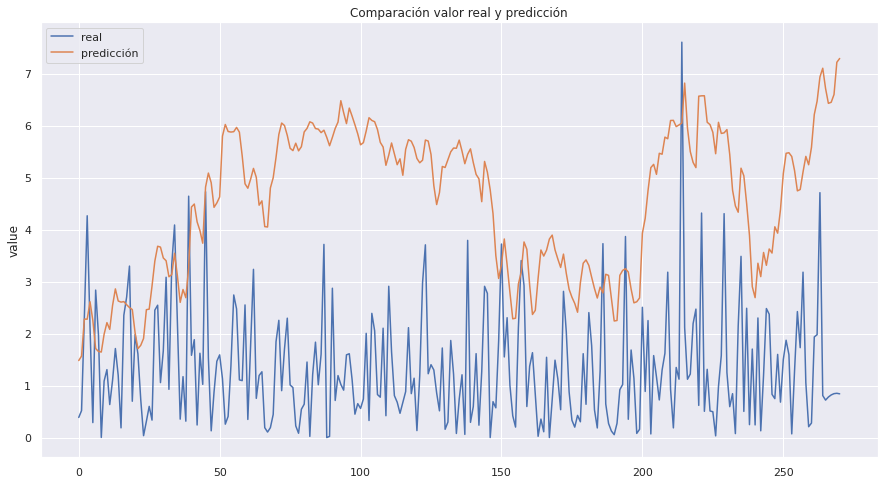

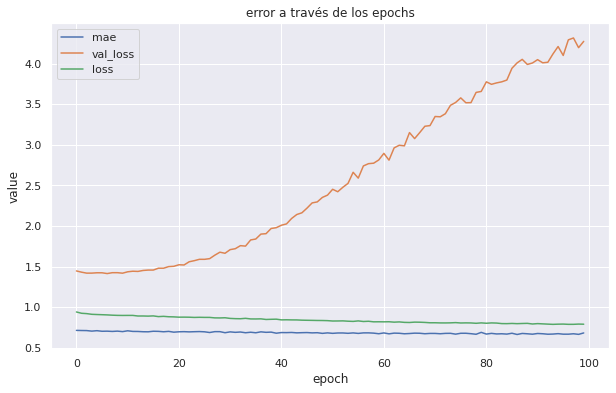

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 2.3115904403031156
MAE is : 1.0718063270441682
RMSE is : 1.5203915417757083
MAPE is : 54.67144175761776
Evaluation metric results:
MSE is : 21.61057697548053
MAE is : 4.194072383008545
RMSE is : 4.648717777568405
MAPE is : 231.85385987087992
(637, 5, 3) (637, 1)
(271, 5, 3) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 31ms/step - loss: 0.9471 - mae: 0.7182 - val_loss: 1.4235 - val_mae: 0.7889
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9299 - mae: 0.7155 - val_loss: 1.4186 - val_mae: 0.7880
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9248 - mae: 0.7158 - val_loss: 1.4117 - val_mae: 0.7894
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9126 - mae: 0.7049 - val_loss: 1.4157 - val_mae: 0.7928
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9103 - mae: 0.7130 - val_

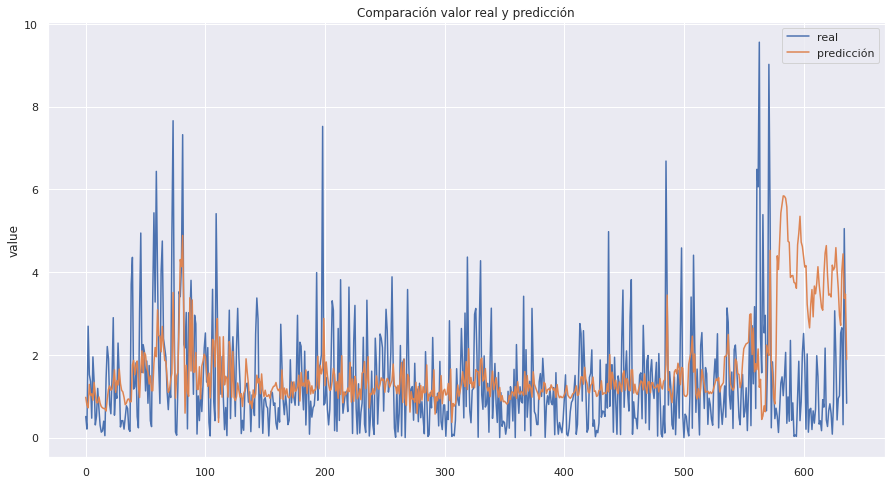

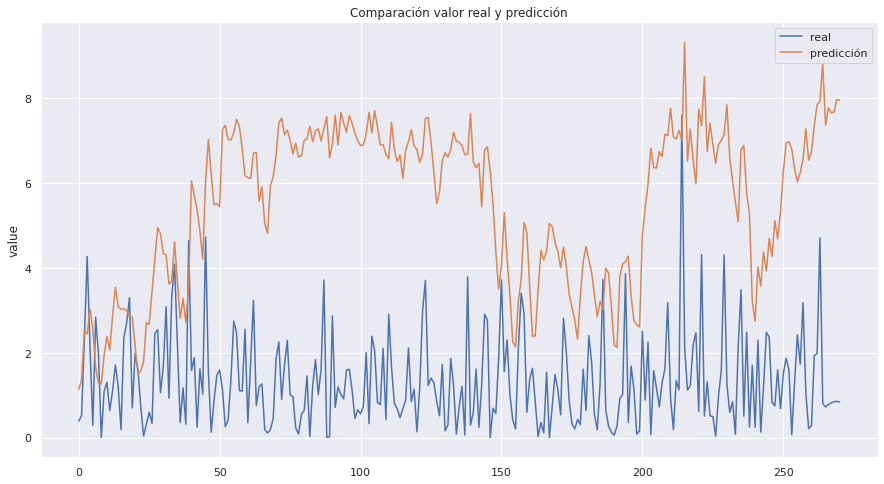

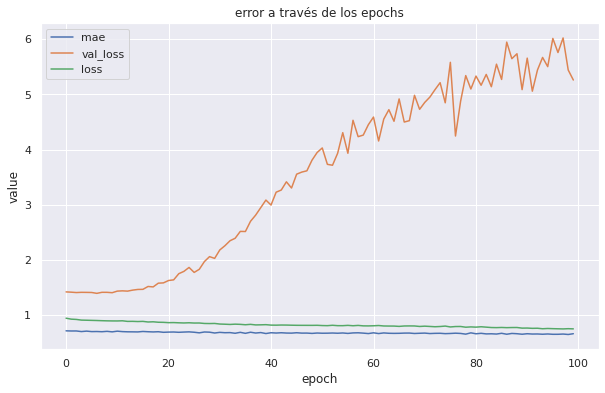

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 2.5705536417308514
MAE is : 1.096143634054044
RMSE is : 1.6032946210010346
MAPE is : 56.720439339318496
Evaluation metric results:
MSE is : 30.441344281387607
MAE is : 5.049242745119808
RMSE is : 5.517367513714091
MAPE is : 276.0027757784957
(637, 5, 3) (637, 1)
(271, 5, 3) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 49ms/step - loss: 0.9541 - mae: 0.7222 - val_loss: 1.4245 - val_mae: 0.7833
Epoch 2/100
32/32 [==============================] - 1s 30ms/step - loss: 0.9275 - mae: 0.7136 - val_loss: 1.4073 - val_mae: 0.7829
Epoch 3/100
32/32 [==============================] - 1s 29ms/step - loss: 0.9231 - mae: 0.7168 - val_loss: 1.4007 - val_mae: 0.7821
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 0.9087 - mae: 0.7022 - val_loss: 1.4025 - val_mae: 0.7875
Epoch 5/100
32/32 [==============================] - 1s 29ms/step - loss: 0.9053 - mae: 0.7127 - val_

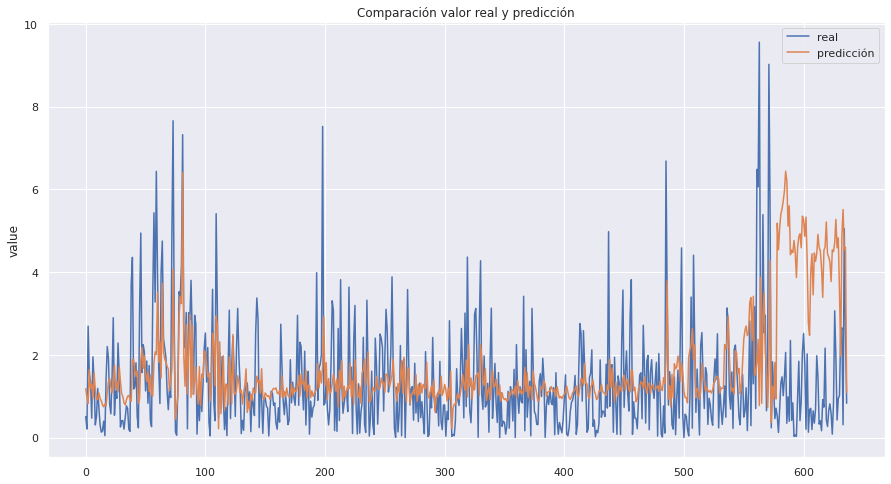

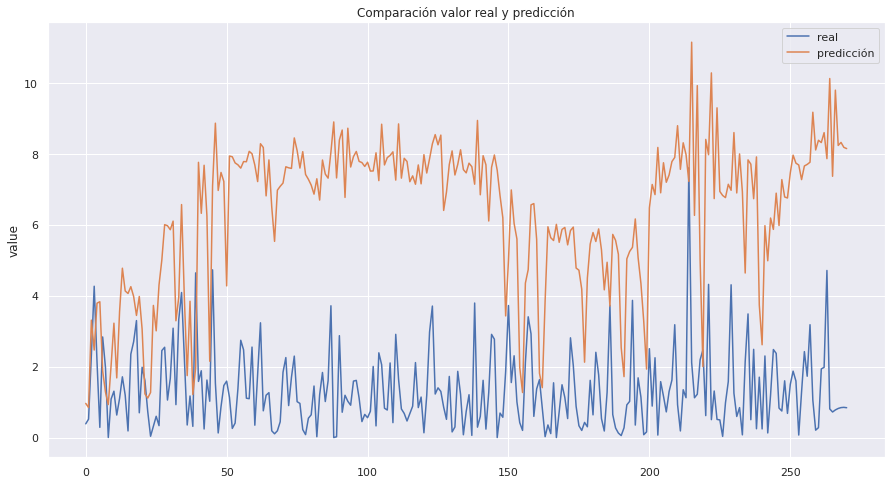

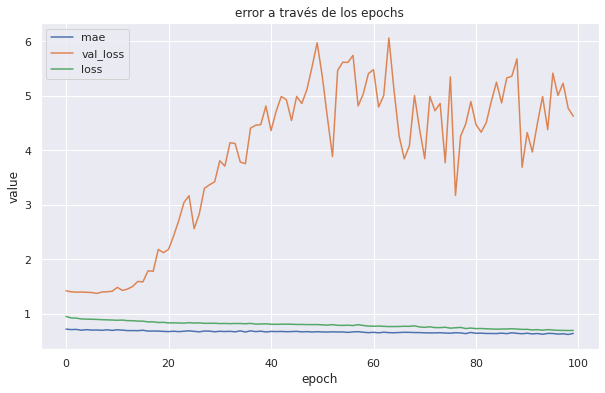

9/9 [==============================] - 0s 10ms/step
Evaluation metric results:
MSE is : 2.288233935901018
MAE is : 1.0345670894788326
RMSE is : 1.5126909584911976
MAPE is : 52.90569983188842
Evaluation metric results:
MSE is : 28.02146757269317
MAE is : 4.72740037907952
RMSE is : 5.293530728416826
MAPE is : 258.21960701002837
(634, 8, 3) (634, 1)
(268, 8, 3) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 29ms/step - loss: 1.0247 - mae: 0.7330 - val_loss: 1.5342 - val_mae: 0.8136
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9815 - mae: 0.7141 - val_loss: 1.5133 - val_mae: 0.8136
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9604 - mae: 0.7065 - val_loss: 1.4987 - val_mae: 0.8161
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9469 - mae: 0.7045 - val_loss: 1.4853 - val_mae: 0.8167
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9381 - mae: 0.7054 - val_loss

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8802 - mae: 0.6927 - val_loss: 1.4049 - val_mae: 0.8213
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8804 - mae: 0.6917 - val_loss: 1.4072 - val_mae: 0.8217
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8790 - mae: 0.6921 - val_loss: 1.4070 - val_mae: 0.8217
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8785 - mae: 0.6927 - val_loss: 1.4074 - val_mae: 0.8226
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8781 - mae: 0.6922 - val_loss: 1.4091 - val_mae: 0.8229
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8767 - mae: 0.6919 - val_loss: 1.4088 - val_mae: 0.8217
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8768 - mae: 0.6914 - val_loss: 1.4098 - val_mae: 0.8224
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

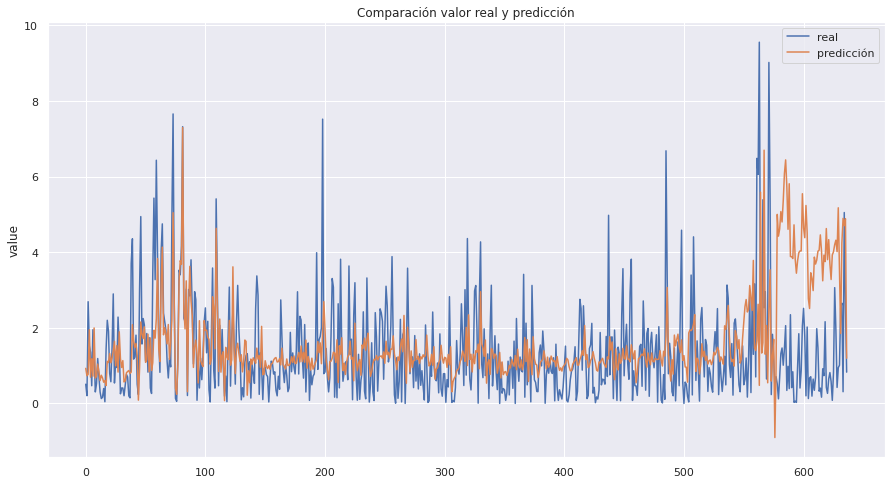

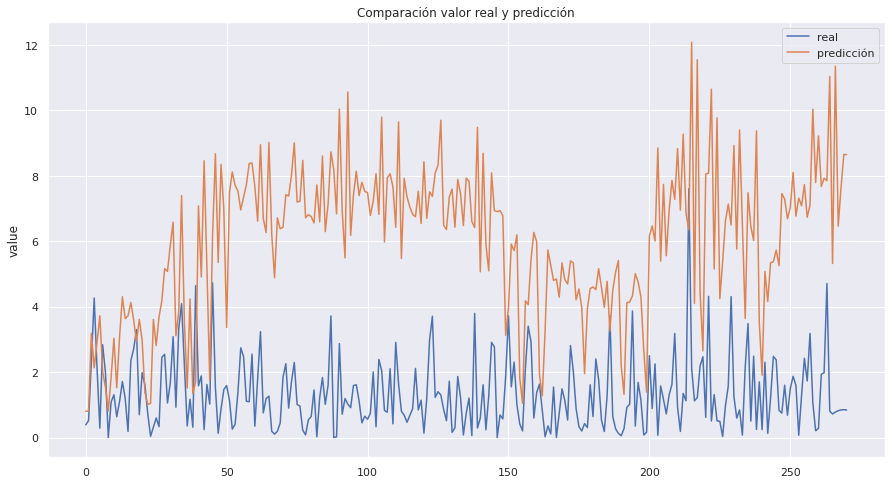

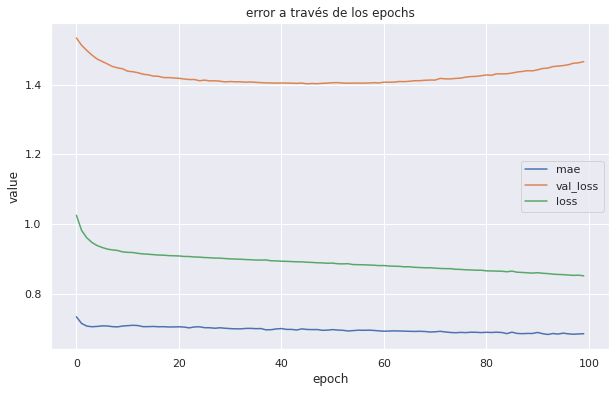

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.5154686577787313
MAE is : 0.8941173990011592
RMSE is : 1.2310437269970271
MAPE is : 44.307110966988304
Evaluation metric results:
MSE is : 1.6432657536401534
MAE is : 1.091871213962375
RMSE is : 1.2818992759340155
MAPE is : 62.577935190653356
(634, 8, 3) (634, 1)
(268, 8, 3) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 30ms/step - loss: 1.0285 - mae: 0.7361 - val_loss: 1.6178 - val_mae: 0.8464
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9675 - mae: 0.7163 - val_loss: 1.5716 - val_mae: 0.8409
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9467 - mae: 0.7162 - val_loss: 1.5385 - val_mae: 0.8376
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9337 - mae: 0.7145 - val_loss: 1.5117 - val_mae: 0.8330
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9241 - mae: 0.7133 - val_

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8488 - mae: 0.6899 - val_loss: 1.5943 - val_mae: 0.9156
Epoch 61/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8490 - mae: 0.6840 - val_loss: 1.6074 - val_mae: 0.9193
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8475 - mae: 0.6901 - val_loss: 1.6097 - val_mae: 0.9206
Epoch 63/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8458 - mae: 0.6887 - val_loss: 1.6177 - val_mae: 0.9250
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8452 - mae: 0.6870 - val_loss: 1.6257 - val_mae: 0.9274
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8433 - mae: 0.6888 - val_loss: 1.6329 - val_mae: 0.9294
Epoch 66/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8438 - mae: 0.6850 - val_loss: 1.6452 - val_mae: 0.9341
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss:

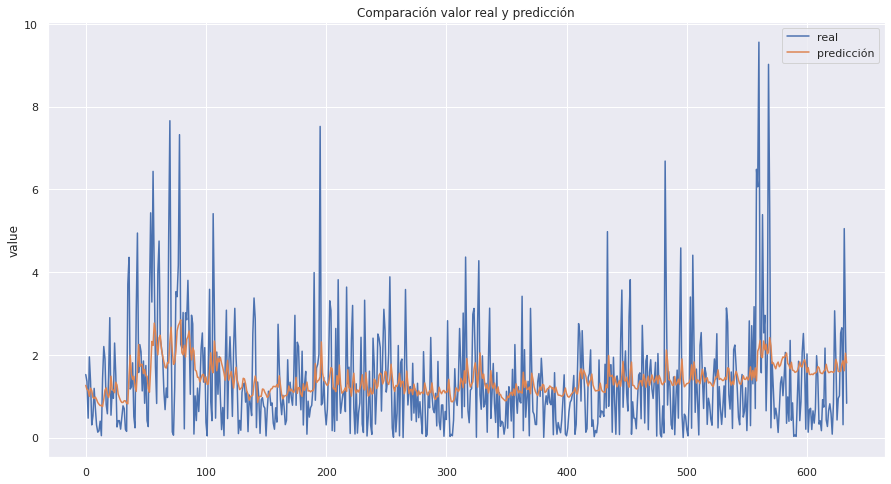

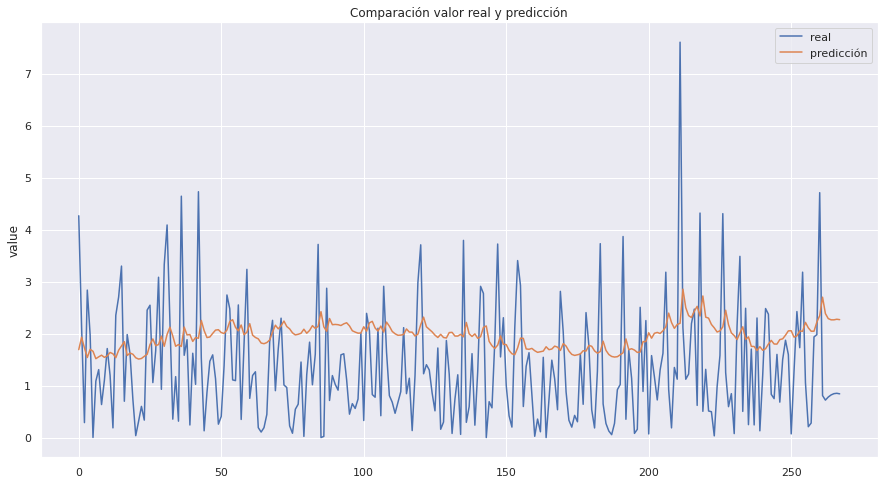

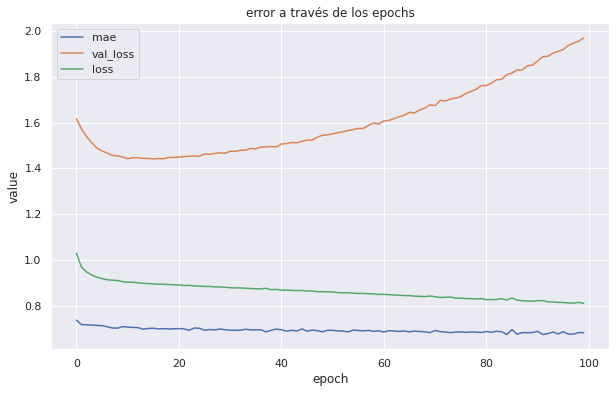

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.6179752970298973
MAE is : 0.9432410516408551
RMSE is : 1.2719965790165857
MAPE is : 47.834018175634334
Evaluation metric results:
MSE is : 3.2762575061306003
MAE is : 1.623209866539588
RMSE is : 1.8100435094578804
MAPE is : 97.18914536368018
(634, 8, 3) (634, 1)
(268, 8, 3) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 33ms/step - loss: 0.9458 - mae: 0.7236 - val_loss: 1.4547 - val_mae: 0.8011
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9232 - mae: 0.7048 - val_loss: 1.4269 - val_mae: 0.7981
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9180 - mae: 0.7098 - val_loss: 1.4180 - val_mae: 0.7971
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9139 - mae: 0.7056 - val_loss: 1.4071 - val_mae: 0.7956
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9099 - mae: 0.7051 - va

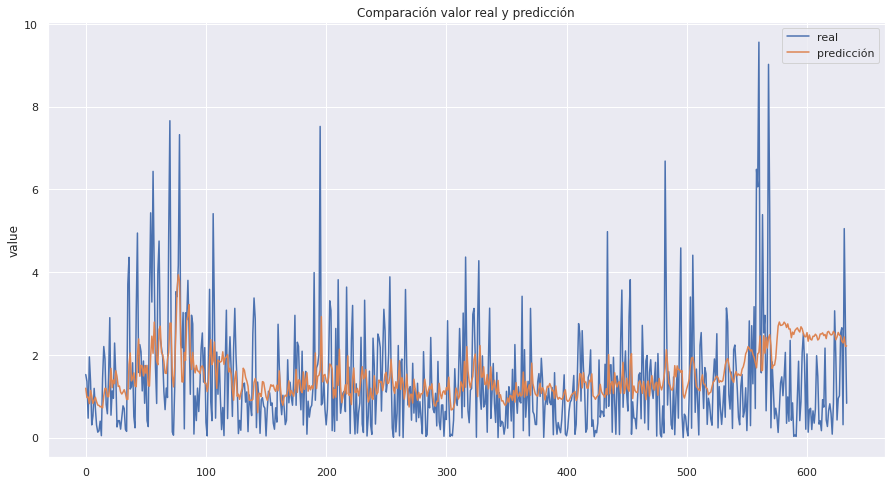

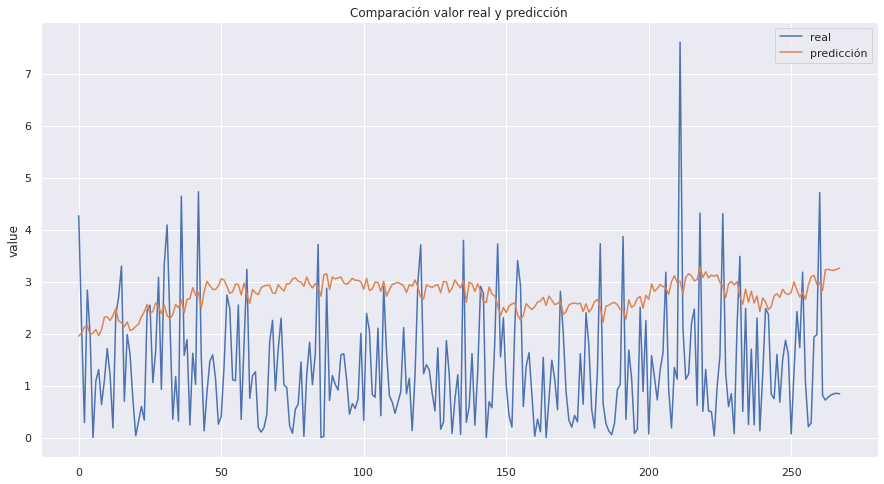

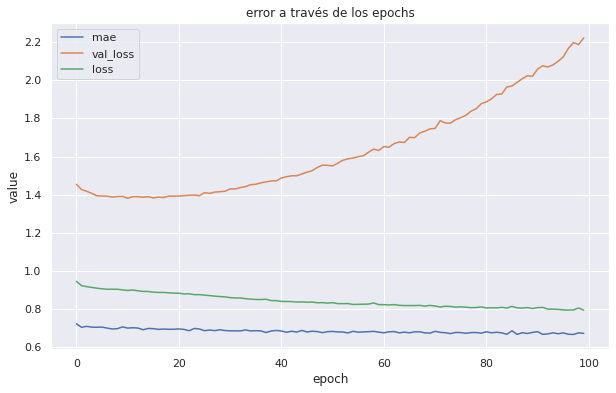

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.6735600802469843
MAE is : 0.9495213142330831
RMSE is : 1.2936615014164194
MAPE is : 47.51574358097279
Evaluation metric results:
MSE is : 6.463028955039205
MAE is : 2.1878799889582607
RMSE is : 2.542248798807702
MAPE is : 125.73528871701103
(634, 8, 3) (634, 1)
(268, 8, 3) (268, 1)
Epoch 1/100
32/32 [==============================] - 5s 38ms/step - loss: 0.9615 - mae: 0.7304 - val_loss: 1.4615 - val_mae: 0.8045
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9245 - mae: 0.7041 - val_loss: 1.4239 - val_mae: 0.8015
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9179 - mae: 0.7092 - val_loss: 1.4214 - val_mae: 0.7982
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9129 - mae: 0.7043 - val_loss: 1.4044 - val_mae: 0.7972
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9078 - mae: 0.7044 - val

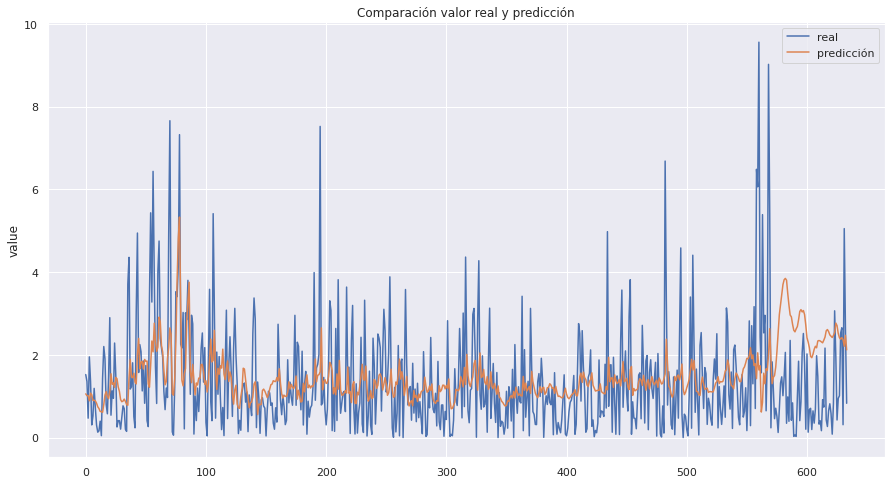

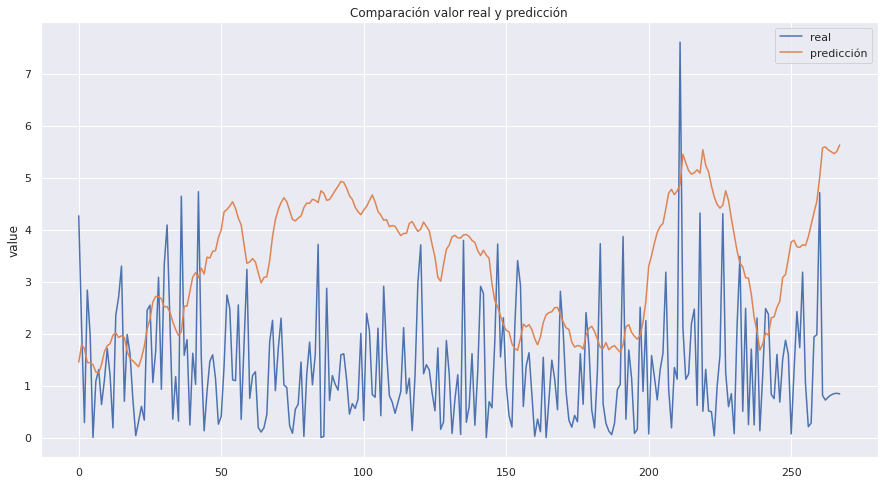

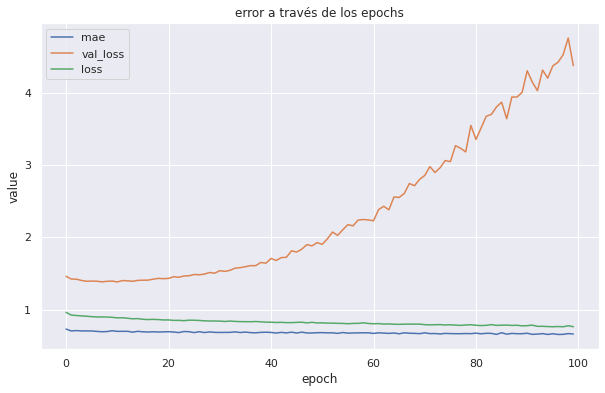

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 2.308922549654988
MAE is : 1.0724862177805445
RMSE is : 1.5195139188750422
MAPE is : 54.63938107535638
Evaluation metric results:
MSE is : 17.251018711445443
MAE is : 3.8658323384208124
RMSE is : 4.153434568094873
MAPE is : 218.1094649801183
(634, 8, 3) (634, 1)
(268, 8, 3) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 46ms/step - loss: 0.9600 - mae: 0.7291 - val_loss: 1.4259 - val_mae: 0.7962
Epoch 2/100
32/32 [==============================] - 1s 23ms/step - loss: 0.9252 - mae: 0.7029 - val_loss: 1.3996 - val_mae: 0.7926
Epoch 3/100
32/32 [==============================] - 1s 23ms/step - loss: 0.9166 - mae: 0.7098 - val_loss: 1.4096 - val_mae: 0.7887
Epoch 4/100
32/32 [==============================] - 1s 23ms/step - loss: 0.9097 - mae: 0.7011 - val_loss: 1.3812 - val_mae: 0.7932
Epoch 5/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9022 - mae: 0.7062 - val_

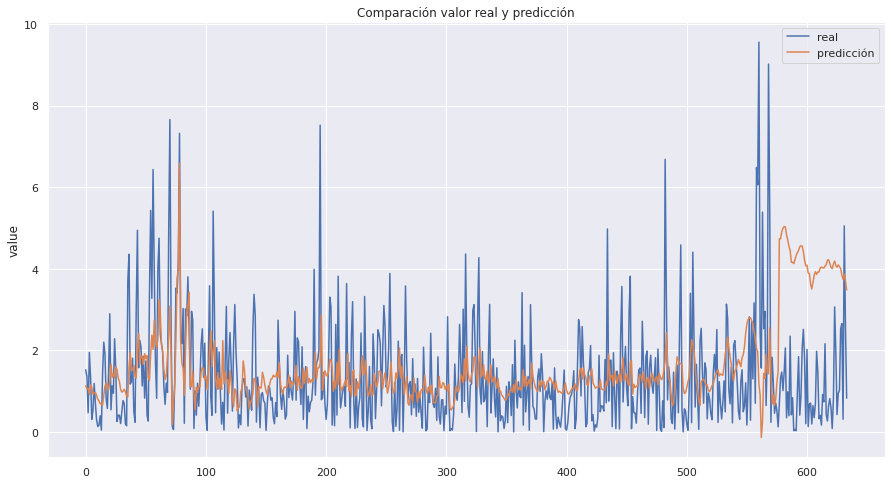

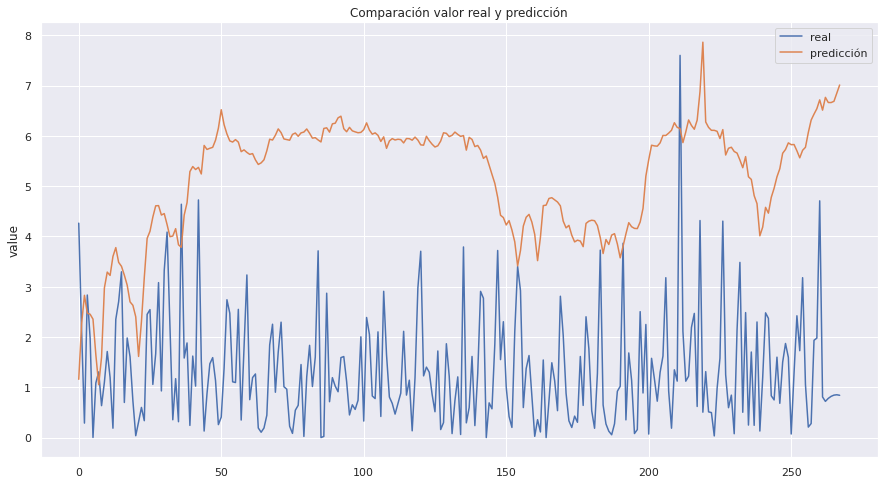

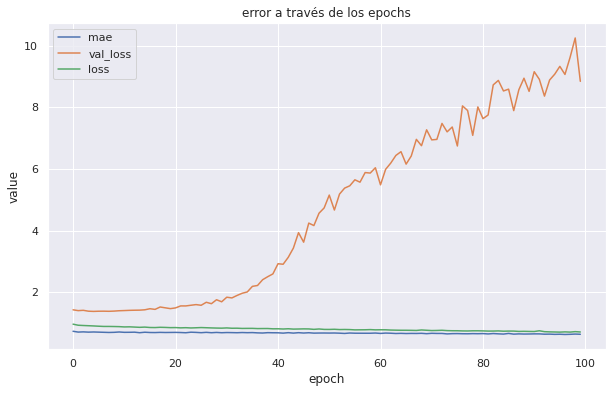

9/9 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 3.634878313570675
MAE is : 1.2267600423823308
RMSE is : 1.9065356837915923
MAPE is : 64.01600796878022
Evaluation metric results:
MSE is : 33.950531802534734
MAE is : 5.505030354826811
RMSE is : 5.826708487863001
MAPE is : 299.22780008958887
(634, 8, 3) (634, 1)
(268, 8, 3) (268, 1)
Epoch 1/100
32/32 [==============================] - 6s 81ms/step - loss: 0.9702 - mae: 0.7303 - val_loss: 1.4070 - val_mae: 0.7870
Epoch 2/100
32/32 [==============================] - 2s 54ms/step - loss: 0.9159 - mae: 0.6977 - val_loss: 1.3700 - val_mae: 0.7809
Epoch 3/100
32/32 [==============================] - 2s 55ms/step - loss: 0.9044 - mae: 0.7066 - val_loss: 1.3796 - val_mae: 0.7748
Epoch 4/100
32/32 [==============================] - 2s 52ms/step - loss: 0.8942 - mae: 0.6961 - val_loss: 1.3440 - val_mae: 0.7887
Epoch 5/100
32/32 [==============================] - 2s 55ms/step - loss: 0.8876 - mae: 0.7055 - val_

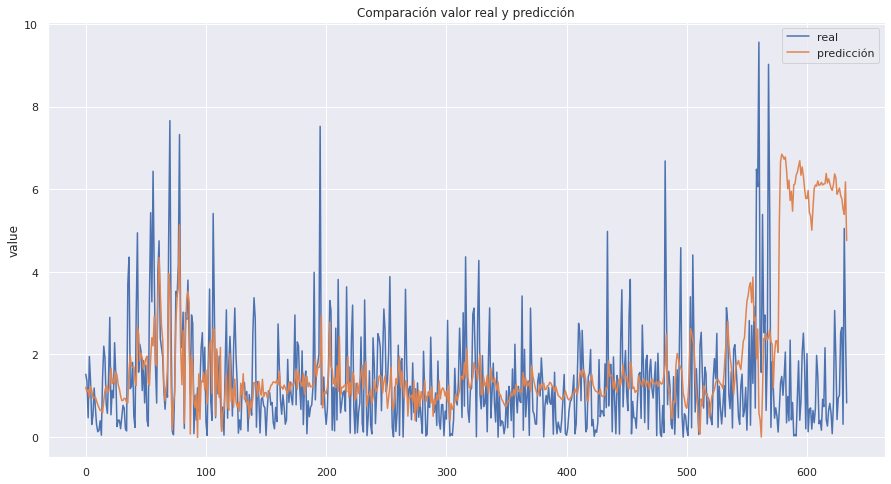

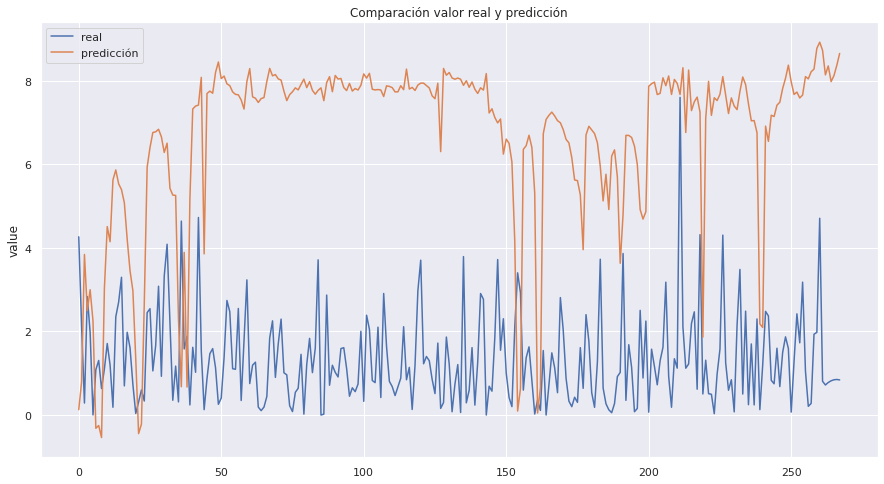

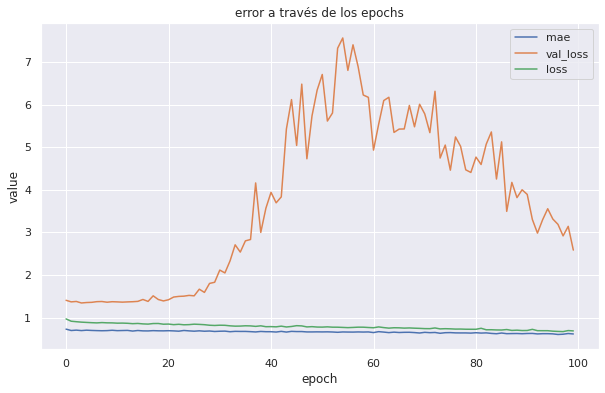

9/9 [==============================] - 0s 19ms/step
Evaluation metric results:
MSE is : 1.6580260599213545
MAE is : 0.9391133605199218
RMSE is : 1.287643607494463
MAPE is : 49.06668417918053
Evaluation metric results:
MSE is : 4.487812685653557
MAE is : 1.8578931571531903
RMSE is : 2.1184458184370816
MAPE is : 105.31235533815271
(632, 10, 3) (632, 1)
(266, 10, 3) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 46ms/step - loss: 0.9660 - mae: 0.6843 - val_loss: 1.4889 - val_mae: 0.8281
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9342 - mae: 0.7049 - val_loss: 1.4809 - val_mae: 0.8291
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9233 - mae: 0.7061 - val_loss: 1.4717 - val_mae: 0.8314
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9198 - mae: 0.7065 - val_loss: 1.4662 - val_mae: 0.8318
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9157 - mae: 0.7034 - 

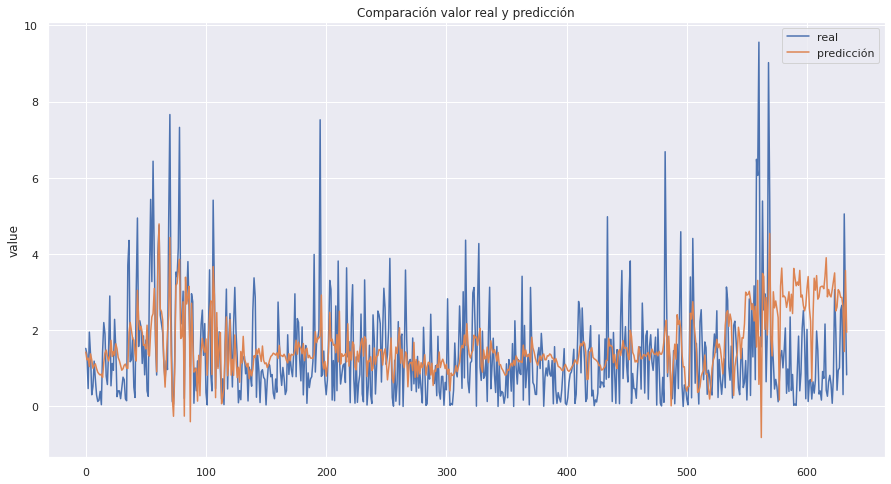

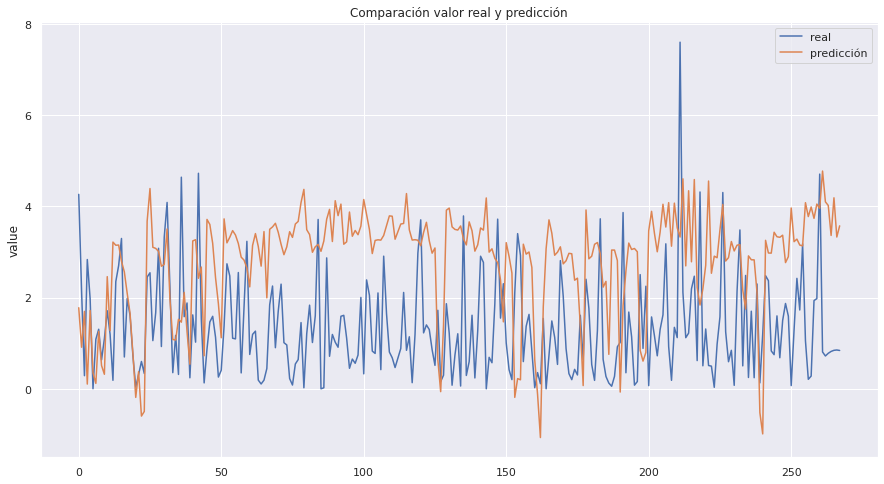

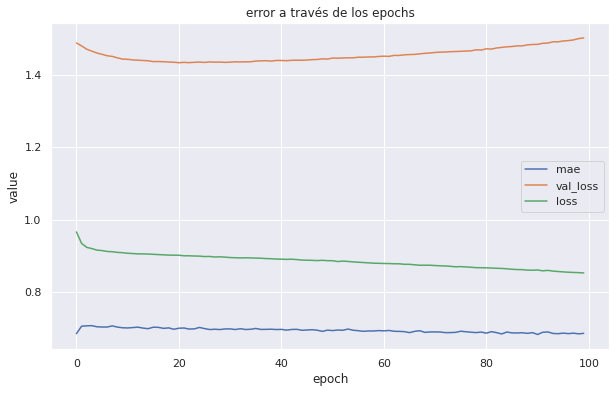

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.5288231246092365
MAE is : 0.9028979877899521
RMSE is : 1.2364558724876664
MAPE is : 44.880025592524305
Evaluation metric results:
MSE is : 2.204834257246916
MAE is : 1.3023102152919108
RMSE is : 1.4848684309550513
MAPE is : 76.74920884330551
(632, 10, 3) (632, 1)
(266, 10, 3) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 40ms/step - loss: 0.9625 - mae: 0.7094 - val_loss: 1.5013 - val_mae: 0.8065
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9475 - mae: 0.7279 - val_loss: 1.4699 - val_mae: 0.8021
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9328 - mae: 0.7136 - val_loss: 1.4420 - val_mae: 0.8002
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9256 - mae: 0.7124 - val_loss: 1.4277 - val_mae: 0.7981
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9186 - mae: 0.7049 - 

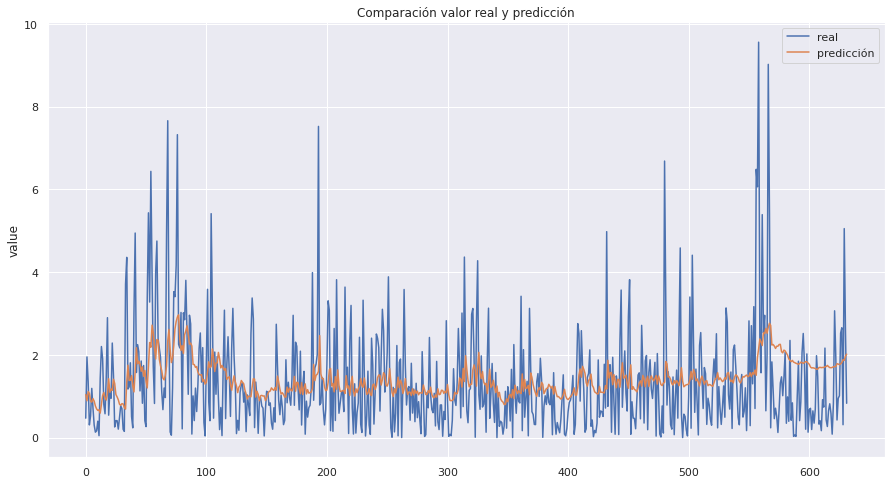

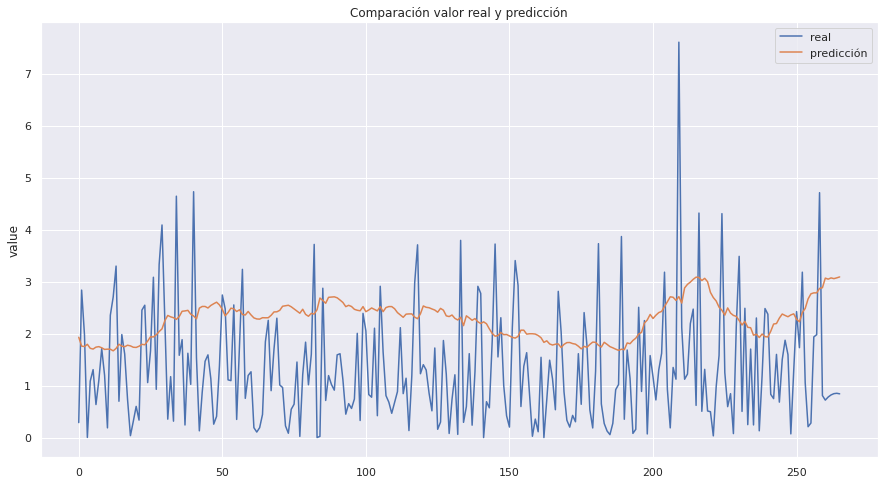

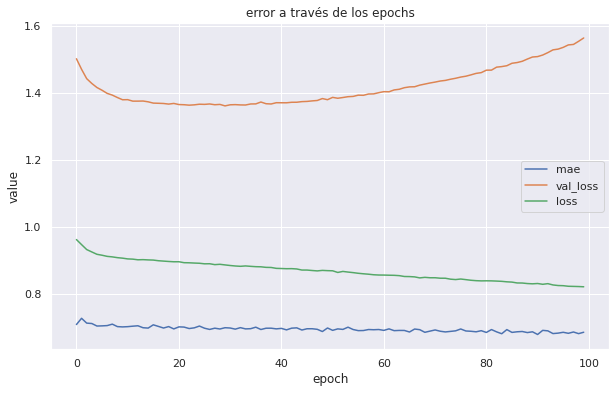

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.506821406542798
MAE is : 0.9037976271992969
RMSE is : 1.2275265400563844
MAPE is : 44.667792112971256
Evaluation metric results:
MSE is : 1.765098140362383
MAE is : 1.1451783742916342
RMSE is : 1.3285699606578432
MAPE is : 66.05674787494613
(632, 10, 3) (632, 1)
(266, 10, 3) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.9556 - mae: 0.7127 - val_loss: 1.4474 - val_mae: 0.7895
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9405 - mae: 0.7345 - val_loss: 1.4192 - val_mae: 0.7852
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9287 - mae: 0.7081 - val_loss: 1.3966 - val_mae: 0.7870
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9236 - mae: 0.7120 - val_loss: 1.3946 - val_mae: 0.7855
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9165 - mae: 0.7008 - v

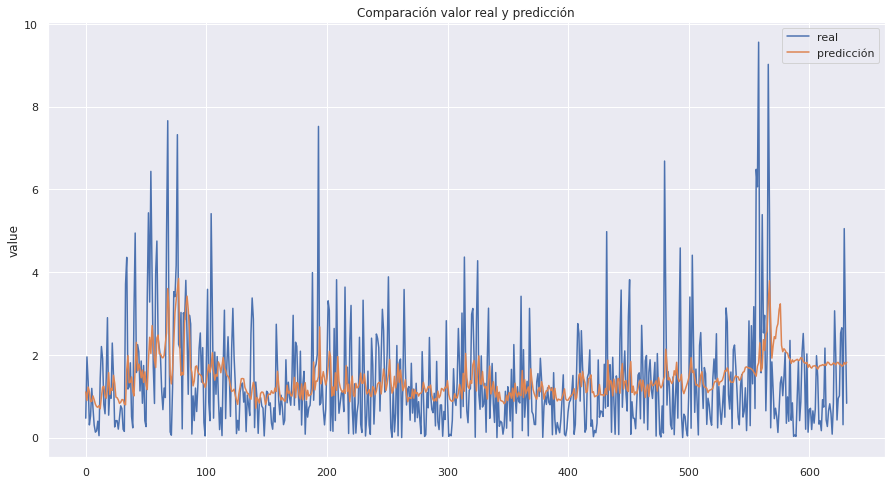

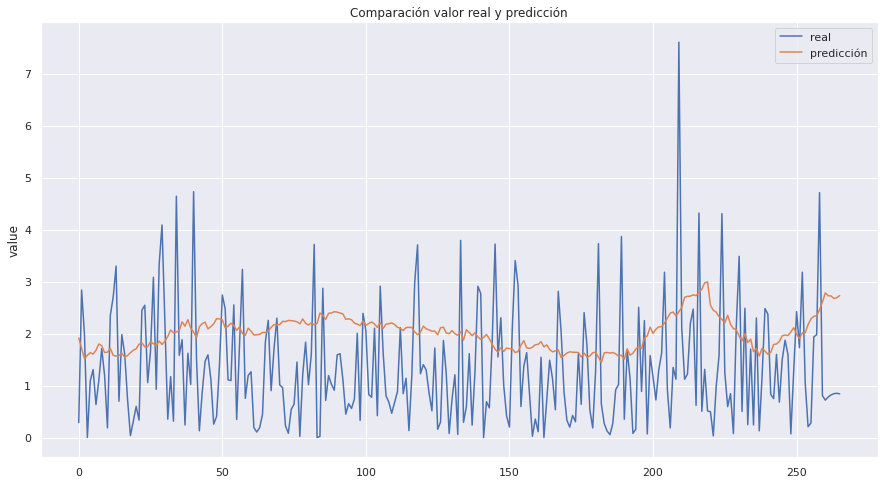

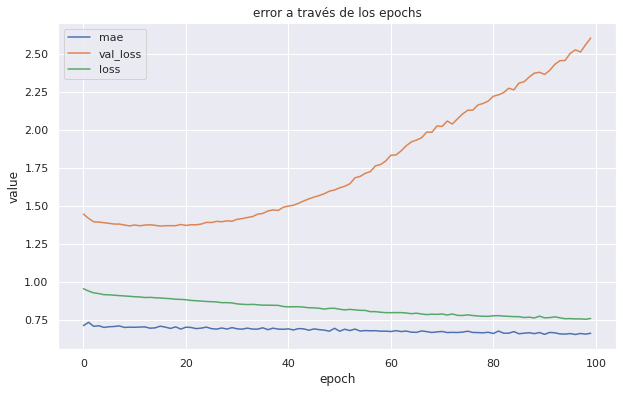

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.7469643270313342
MAE is : 0.9512530891219579
RMSE is : 1.3217277809864383
MAPE is : 47.14457197948006
Evaluation metric results:
MSE is : 4.544766719891651
MAE is : 1.8585413711615861
RMSE is : 2.1318458480602325
MAPE is : 109.18988026940333
(632, 10, 3) (632, 1)
(266, 10, 3) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 53ms/step - loss: 0.9455 - mae: 0.7081 - val_loss: 1.4098 - val_mae: 0.7895
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9275 - mae: 0.7332 - val_loss: 1.3950 - val_mae: 0.7953
Epoch 3/100
32/32 [==============================] - 0s 16ms/step - loss: 0.9273 - mae: 0.7054 - val_loss: 1.3734 - val_mae: 0.7923
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9159 - mae: 0.7126 - val_loss: 1.3774 - val_mae: 0.7928
Epoch 5/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9076 - mae: 0.6941 - 

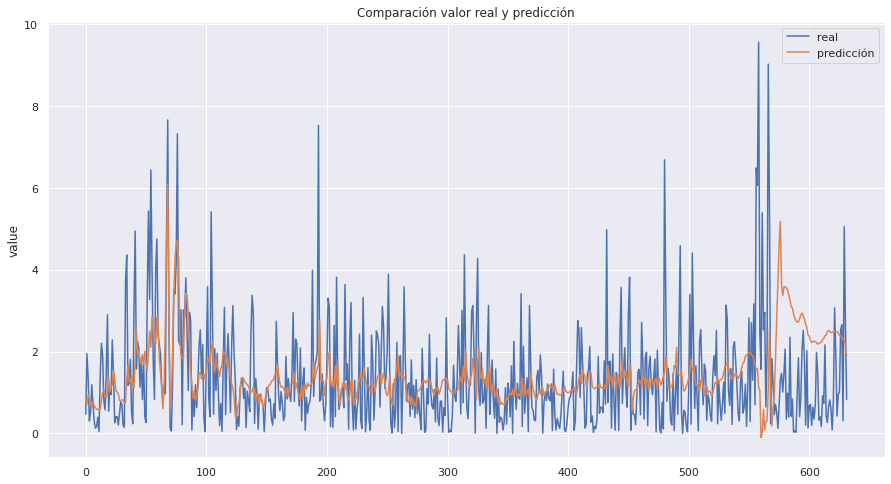

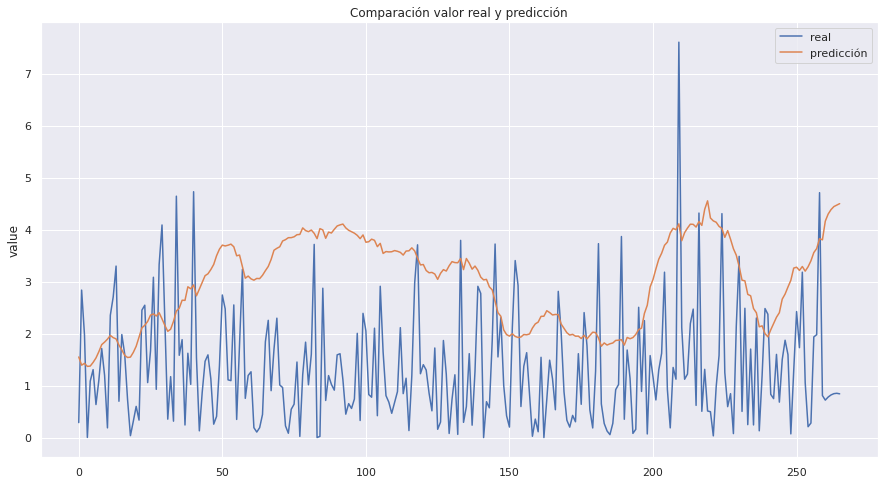

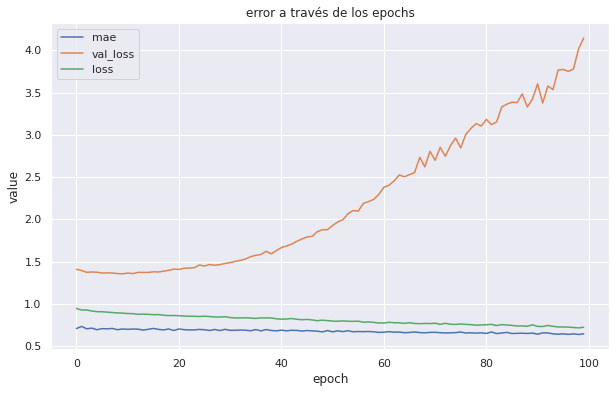

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 2.1777542323728456
MAE is : 1.0297691393764556
RMSE is : 1.4757215971763935
MAPE is : 52.266410896695284
Evaluation metric results:
MSE is : 13.79759859784289
MAE is : 3.3688471033485703
RMSE is : 3.7145118922737197
MAPE is : 191.41901181524997
(632, 10, 3) (632, 1)
(266, 10, 3) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 44ms/step - loss: 0.9561 - mae: 0.7142 - val_loss: 1.3932 - val_mae: 0.7870
Epoch 2/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9255 - mae: 0.7284 - val_loss: 1.3951 - val_mae: 0.7985
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.9295 - mae: 0.7089 - val_loss: 1.3721 - val_mae: 0.7931
Epoch 4/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9190 - mae: 0.7097 - val_loss: 1.3793 - val_mae: 0.7931
Epoch 5/100
32/32 [==============================] - 1s 27ms/step - loss: 0.9059 - mae: 0.6947 -

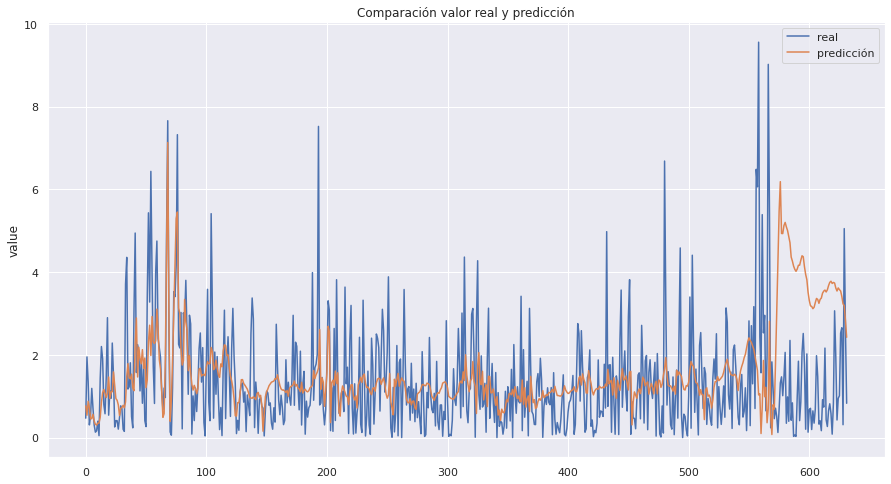

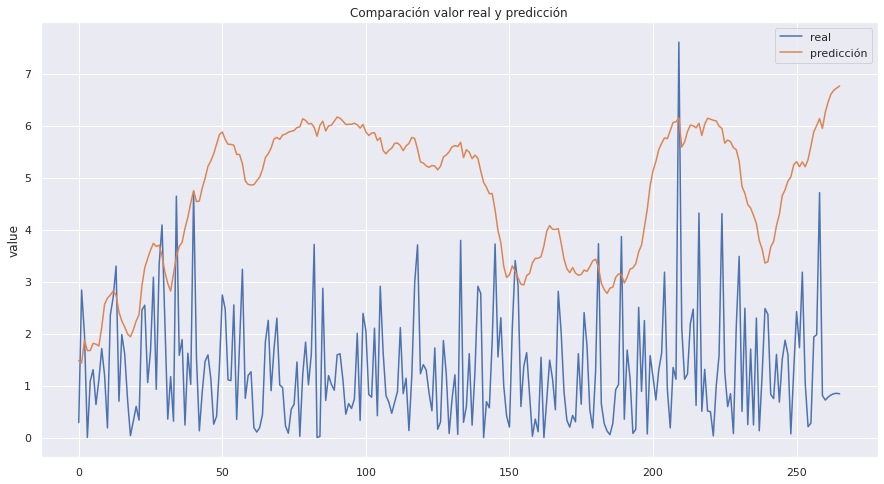

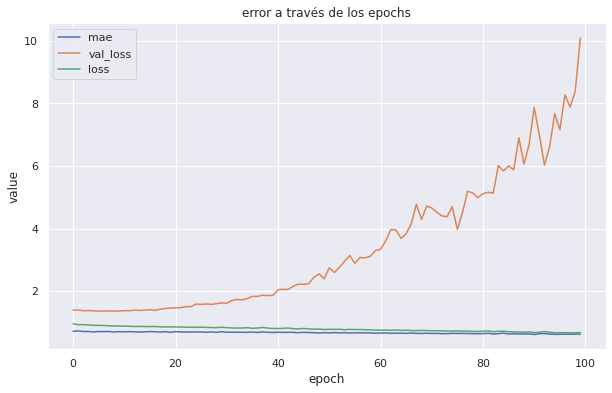

9/9 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 3.971567075215808
MAE is : 1.23121393872391
RMSE is : 1.9928790919711632
MAPE is : 64.48367665954639
Evaluation metric results:
MSE is : 36.91201103993059
MAE is : 5.494174851876659
RMSE is : 6.075525577259188
MAPE is : 299.6793366953682
(632, 10, 3) (632, 1)
(266, 10, 3) (266, 1)
Epoch 1/100
32/32 [==============================] - 6s 90ms/step - loss: 0.9732 - mae: 0.7193 - val_loss: 1.3821 - val_mae: 0.7832
Epoch 2/100
32/32 [==============================] - 2s 50ms/step - loss: 0.9229 - mae: 0.7278 - val_loss: 1.3825 - val_mae: 0.7911
Epoch 3/100
32/32 [==============================] - 2s 49ms/step - loss: 0.9227 - mae: 0.7072 - val_loss: 1.3491 - val_mae: 0.7910
Epoch 4/100
32/32 [==============================] - 2s 49ms/step - loss: 0.9119 - mae: 0.7081 - val_loss: 1.3666 - val_mae: 0.7861
Epoch 5/100
32/32 [==============================] - 2s 48ms/step - loss: 0.8973 - mae: 0.6941 - val_lo

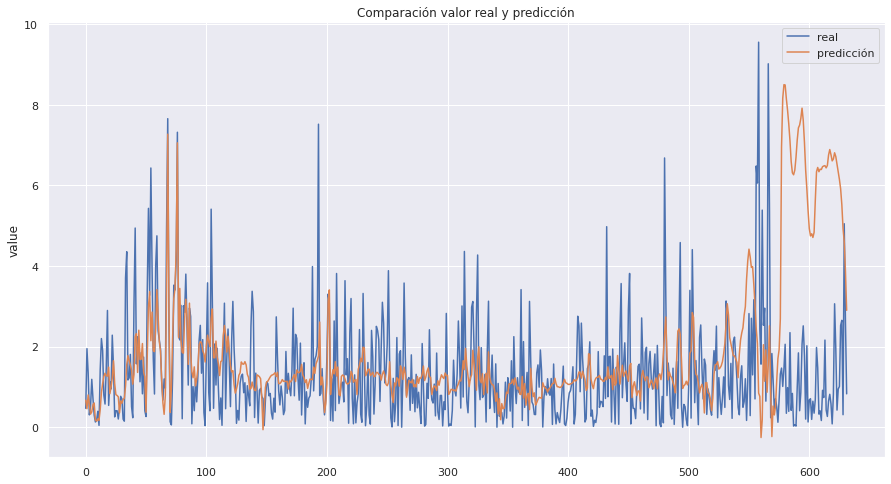

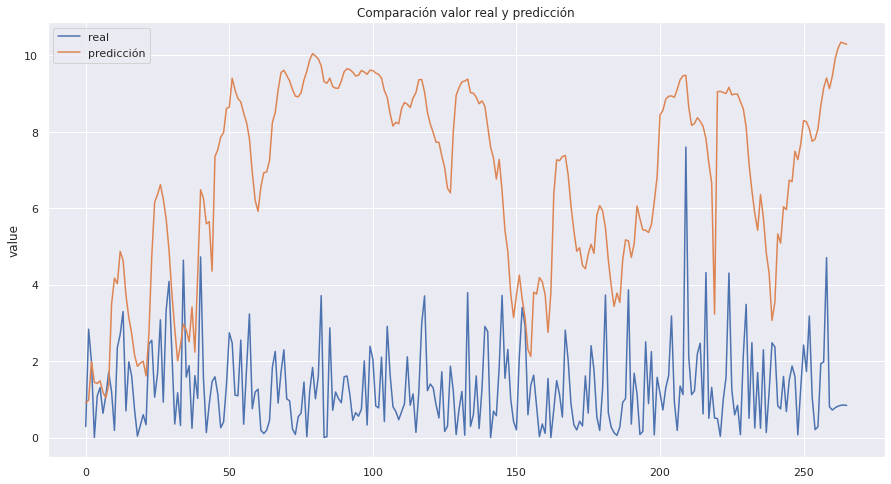

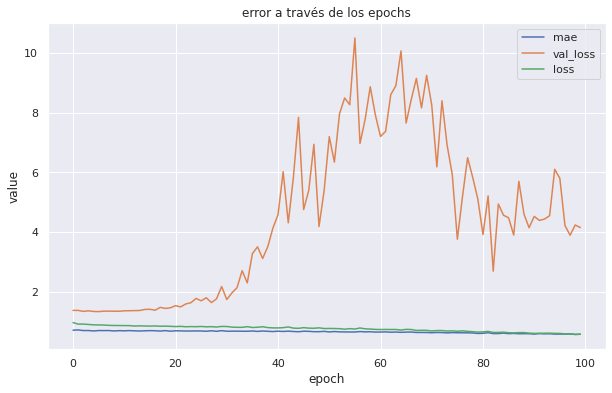

9/9 [==============================] - 0s 16ms/step
Evaluation metric results:
MSE is : 1.9861772004450469
MAE is : 0.9477794660262725
RMSE is : 1.4093179912443632
MAPE is : 48.19544686347566
Evaluation metric results:
MSE is : 5.722178791146585
MAE is : 2.055161846894214
RMSE is : 2.3921076044247225
MAPE is : 116.19902696474038
(627, 15, 3) (627, 1)
(261, 15, 3) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 1.0063 - mae: 0.7274 - val_loss: 1.6424 - val_mae: 0.8476
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9727 - mae: 0.7208 - val_loss: 1.6097 - val_mae: 0.8414
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9560 - mae: 0.7264 - val_loss: 1.5804 - val_mae: 0.8369
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9428 - mae: 0.7189 - val_loss: 1.5547 - val_mae: 0.8322
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9332 - mae: 0.7124 - 

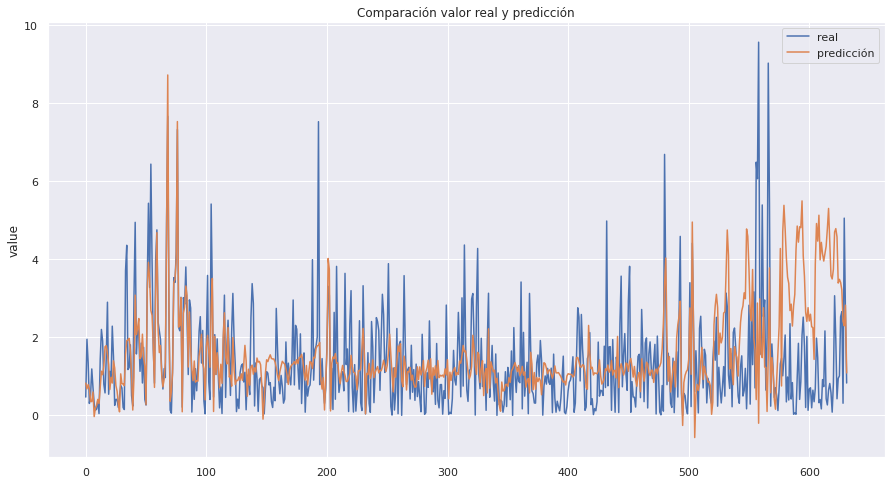

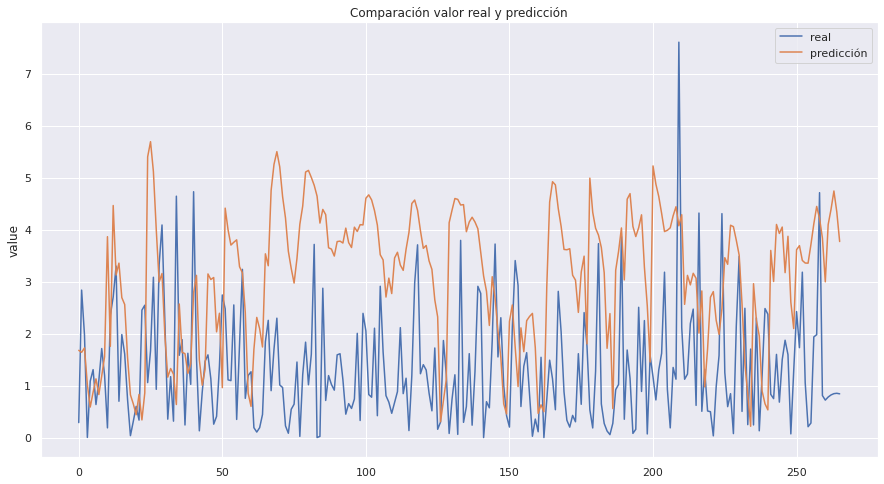

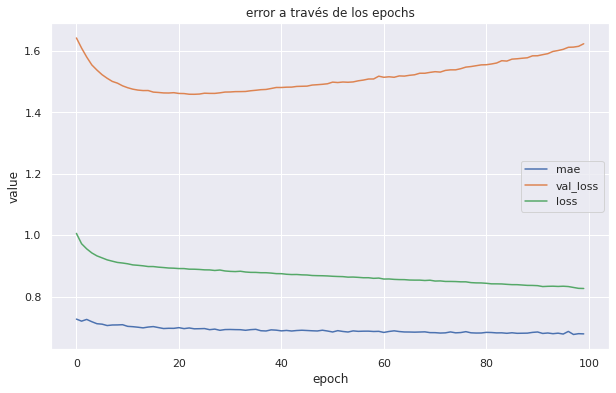

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.5345677209214001
MAE is : 0.8971987428338694
RMSE is : 1.2387767034140575
MAPE is : 44.067390519365304
Evaluation metric results:
MSE is : 1.7380211148614908
MAE is : 1.1298130745555894
RMSE is : 1.318340287961151
MAPE is : 64.8930695928286
(627, 15, 3) (627, 1)
(261, 15, 3) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 53ms/step - loss: 0.9898 - mae: 0.7474 - val_loss: 1.6238 - val_mae: 0.8376
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9586 - mae: 0.7199 - val_loss: 1.5823 - val_mae: 0.8292
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9419 - mae: 0.7268 - val_loss: 1.5474 - val_mae: 0.8228
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9301 - mae: 0.7165 - val_loss: 1.5194 - val_mae: 0.8170
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9224 - mae: 0.7094 - v

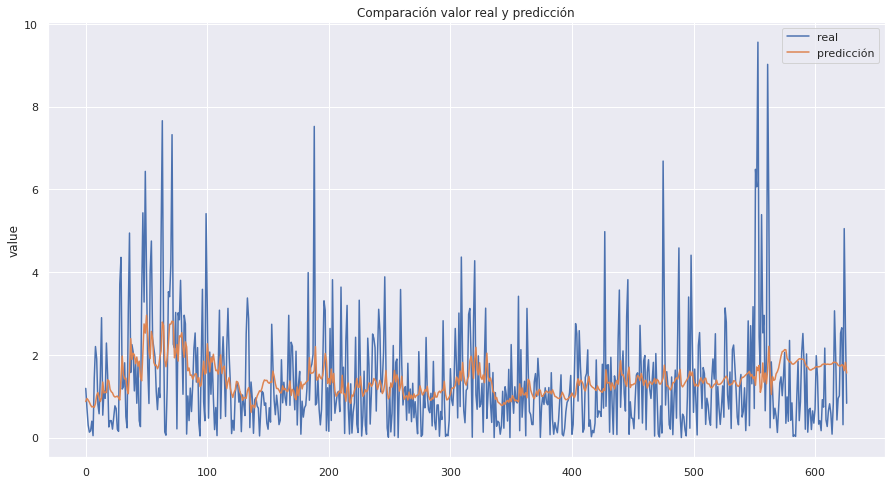

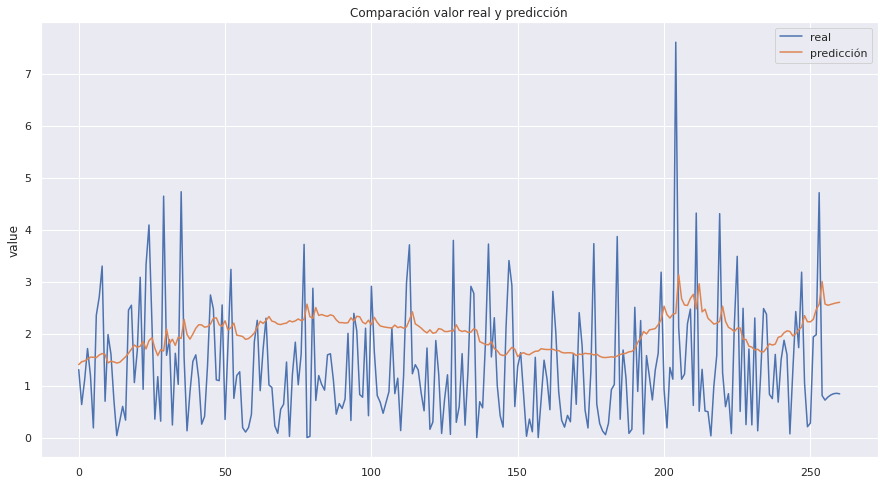

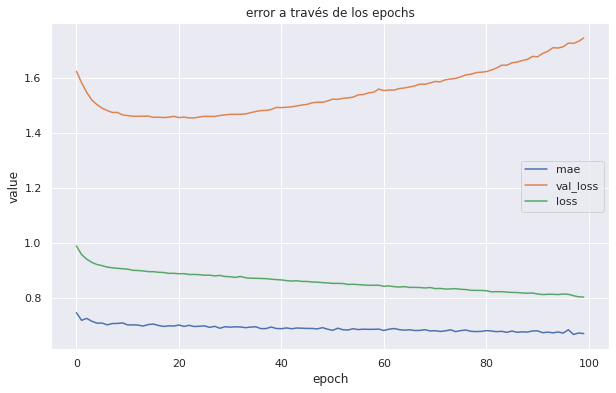

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.5419026024807412
MAE is : 0.9017509254706126
RMSE is : 1.2417337083613142
MAPE is : 44.2489892204291
Evaluation metric results:
MSE is : 2.0662353927329487
MAE is : 1.2531170580473532
RMSE is : 1.4374405701568844
MAPE is : 72.94716211187223
(627, 15, 3) (627, 1)
(261, 15, 3) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.9900 - mae: 0.7419 - val_loss: 1.5016 - val_mae: 0.8025
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9360 - mae: 0.7086 - val_loss: 1.4625 - val_mae: 0.7930
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9287 - mae: 0.7263 - val_loss: 1.4352 - val_mae: 0.7938
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9209 - mae: 0.7073 - val_loss: 1.4217 - val_mae: 0.7934
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9173 - mae: 0.7074 - v

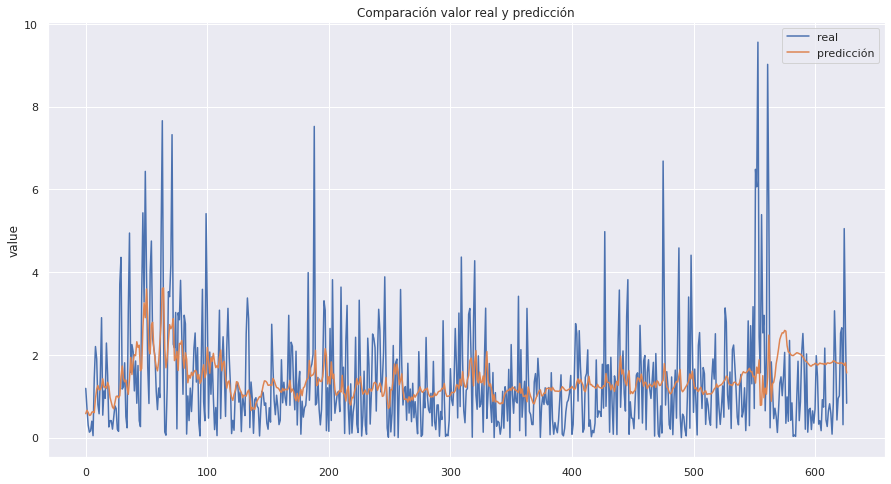

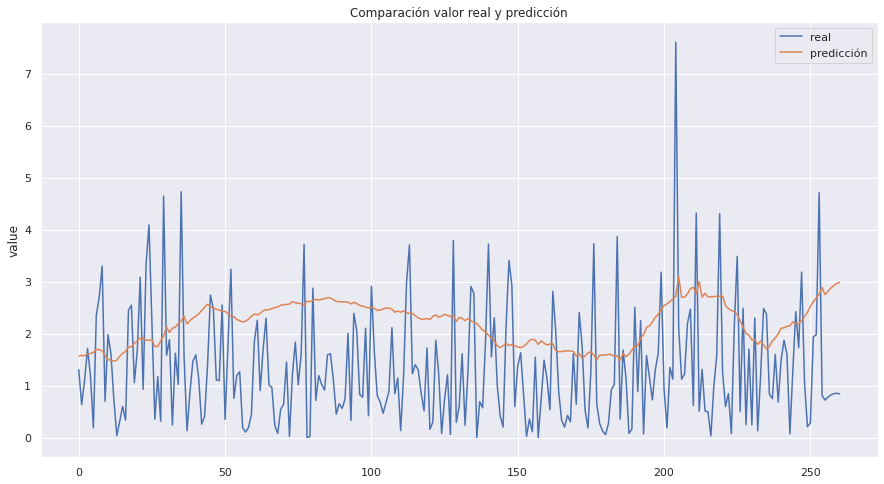

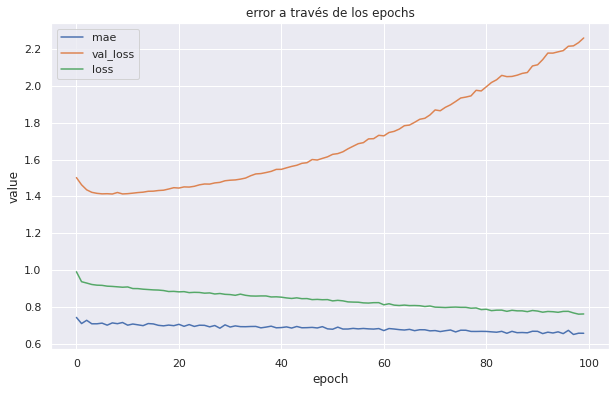

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.6427936829389547
MAE is : 0.9220519796661811
RMSE is : 1.281715133303401
MAPE is : 45.72842998300054
Evaluation metric results:
MSE is : 3.9754724696838237
MAE is : 1.7580540287796977
RMSE is : 1.9938586884942031
MAPE is : 104.08474368348777
(627, 15, 3) (627, 1)
(261, 15, 3) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 59ms/step - loss: 0.9901 - mae: 0.7454 - val_loss: 1.5125 - val_mae: 0.8102
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.9315 - mae: 0.7096 - val_loss: 1.4693 - val_mae: 0.8011
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.9281 - mae: 0.7253 - val_loss: 1.4593 - val_mae: 0.8109
Epoch 4/100
32/32 [==============================] - 1s 18ms/step - loss: 0.9199 - mae: 0.7064 - val_loss: 1.4517 - val_mae: 0.8062
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.9174 - mae: 0.7048 - 

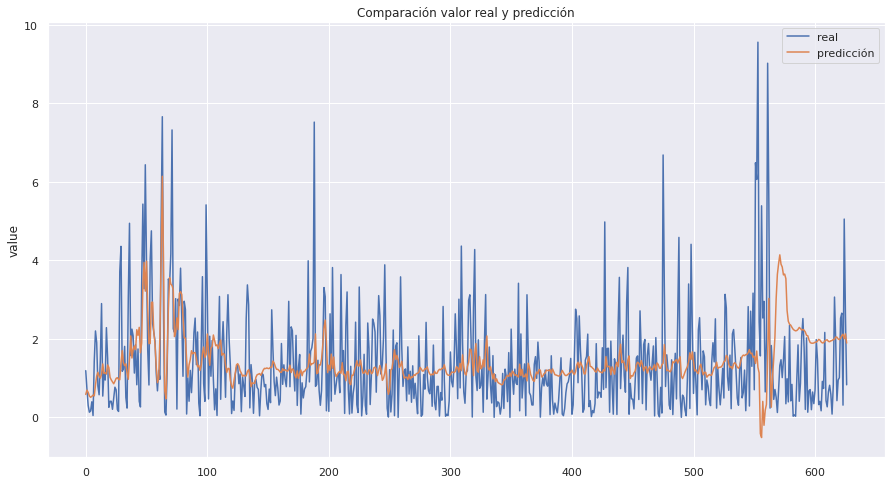

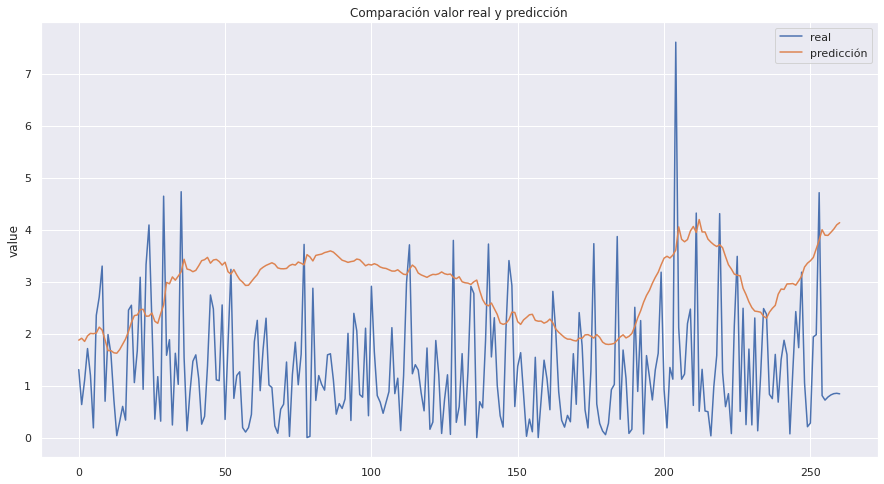

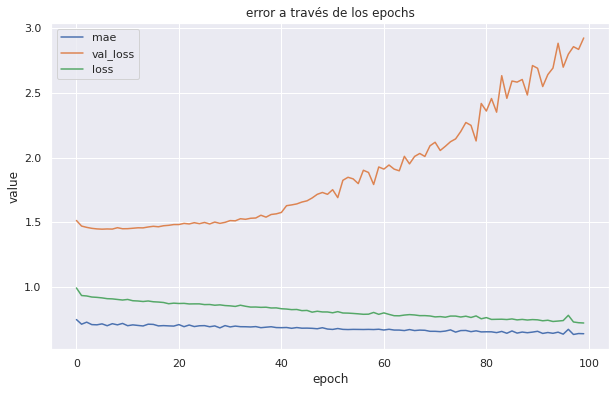

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.7932822347963164
MAE is : 0.9525804392131336
RMSE is : 1.3391348829734504
MAPE is : 48.47589066338153
Evaluation metric results:
MSE is : 10.687702815303332
MAE is : 2.9276082116409463
RMSE is : 3.2692052268561134
MAPE is : 167.37324681141422
(627, 15, 3) (627, 1)
(261, 15, 3) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 55ms/step - loss: 0.9714 - mae: 0.7326 - val_loss: 1.4410 - val_mae: 0.7932
Epoch 2/100
32/32 [==============================] - 1s 31ms/step - loss: 0.9262 - mae: 0.7009 - val_loss: 1.4203 - val_mae: 0.7891
Epoch 3/100
32/32 [==============================] - 1s 33ms/step - loss: 0.9198 - mae: 0.7216 - val_loss: 1.4225 - val_mae: 0.8065
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.9111 - mae: 0.7070 - val_loss: 1.4216 - val_mae: 0.7975
Epoch 5/100
32/32 [==============================] - 1s 30ms/step - loss: 0.9091 - mae: 0.6996 -

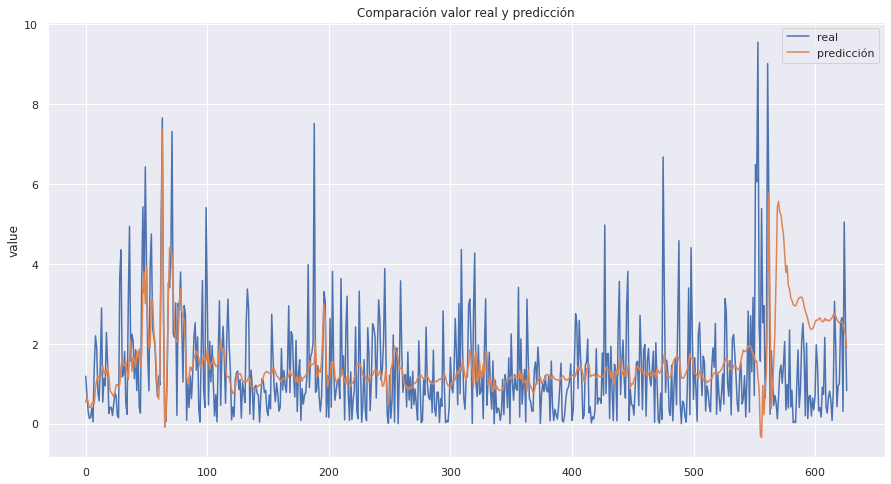

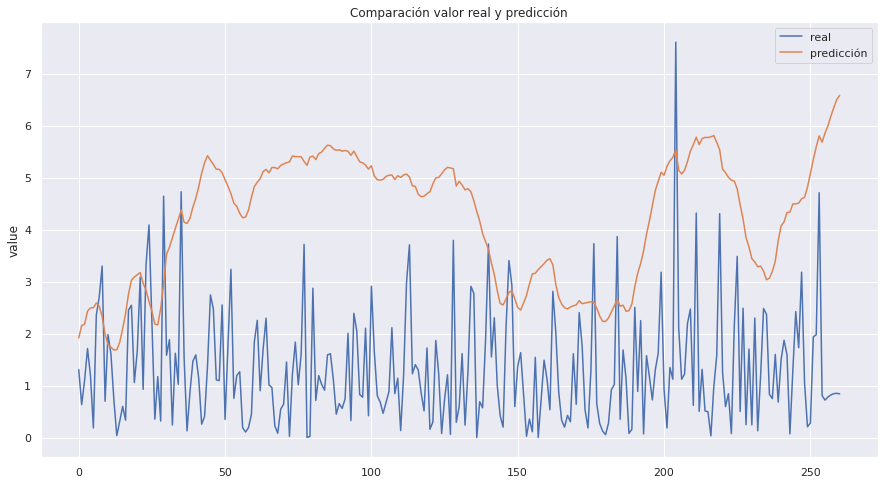

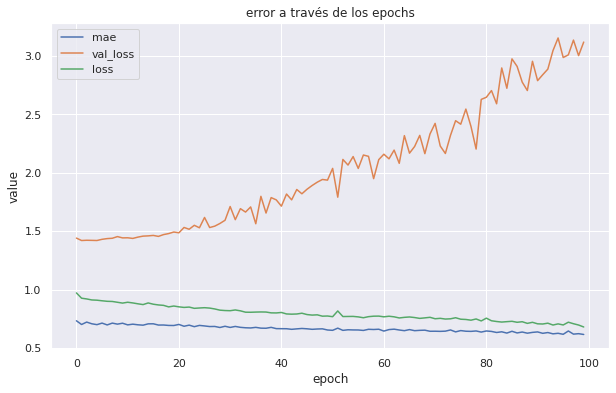

9/9 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 1.7951068977032167
MAE is : 0.9298478482587752
RMSE is : 1.3398159939720142
MAPE is : 47.47291508016589
Evaluation metric results:
MSE is : 5.883209858463489
MAE is : 2.1871287869321856
RMSE is : 2.425532901954432
MAPE is : 128.13864149834117
(627, 15, 3) (627, 1)
(261, 15, 3) (261, 1)
Epoch 1/100
32/32 [==============================] - 6s 90ms/step - loss: 0.9839 - mae: 0.7389 - val_loss: 1.4247 - val_mae: 0.7862
Epoch 2/100
32/32 [==============================] - 2s 69ms/step - loss: 0.9211 - mae: 0.6973 - val_loss: 1.4124 - val_mae: 0.7853
Epoch 3/100
32/32 [==============================] - 2s 69ms/step - loss: 0.9155 - mae: 0.7204 - val_loss: 1.4190 - val_mae: 0.7939
Epoch 4/100
32/32 [==============================] - 2s 69ms/step - loss: 0.9049 - mae: 0.7053 - val_loss: 1.4138 - val_mae: 0.7874
Epoch 5/100
32/32 [==============================] - 2s 69ms/step - loss: 0.9030 - mae: 0.7013 - 

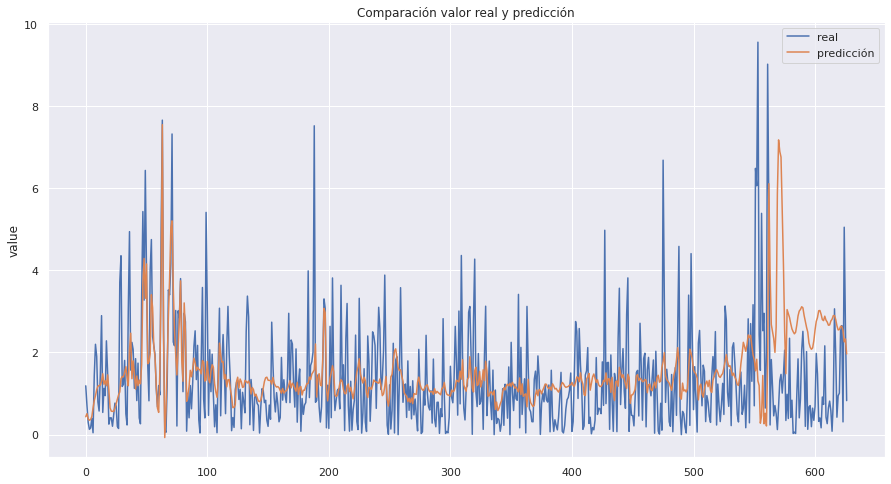

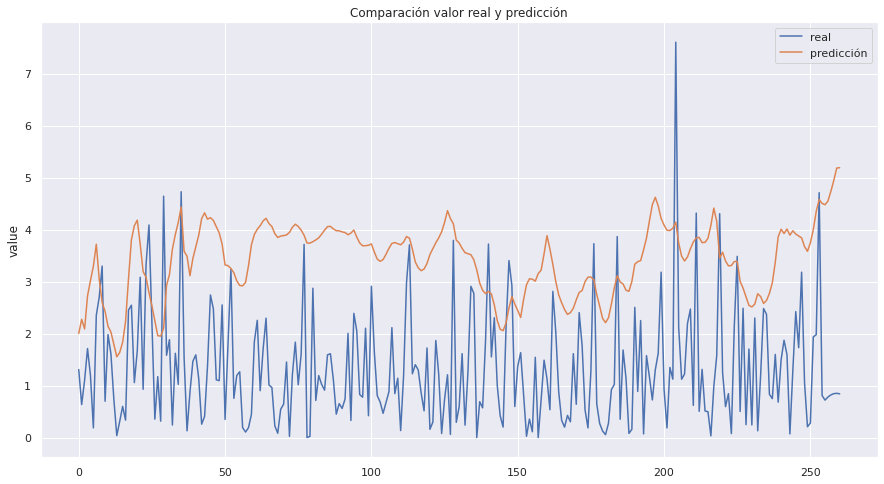

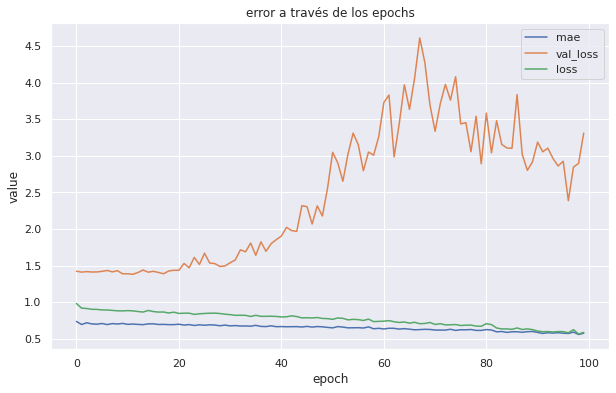

9/9 [==============================] - 0s 22ms/step
Evaluation metric results:
MSE is : 1.6903034961105645
MAE is : 0.821428667729835
RMSE is : 1.3001167240331017
MAPE is : 38.51491555747987
Evaluation metric results:
MSE is : 2.2824989697912907
MAE is : 1.1554007938670097
RMSE is : 1.5107941520244546
MAPE is : 47.839132295879935


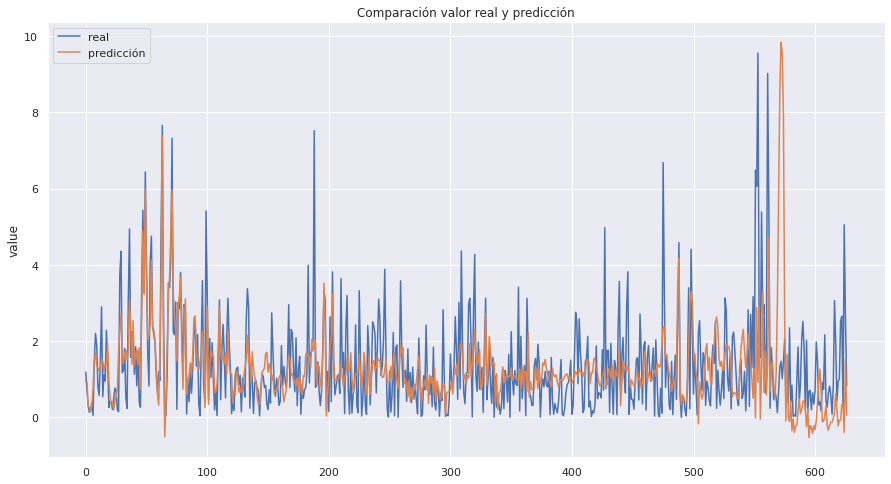

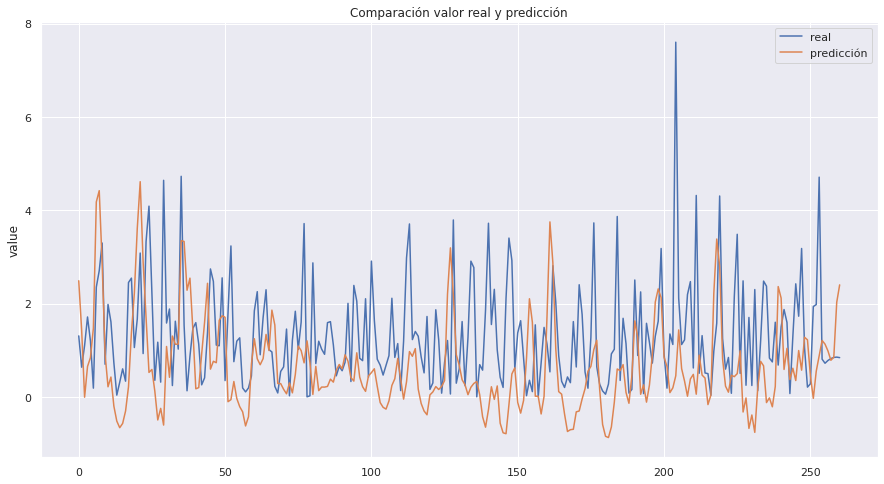

In [12]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=3,epochss=100,batch_sizze=16,lag=lg)